- I tried to use Tensorflow, but 
    - I didn't understand how to access what was happening under the hood.  I like to run my fingers through the numbers, and I couldn't see them, so I think I had problems but couldn't find them, and
    - I think Tensors make the operation too complicated for some of my imbalanced data techniques.
- This attempt is really basic, an adaptation of the Keras example for structured data, "Imbalanced Data: Credit Card Fraud Detection" example at 
https://keras.io/examples/structured_data/imbalanced_classification/

In [1]:
%%latex
\tableofcontents

<IPython.core.display.Latex object>

# Setup

## Import Libraries

In [2]:
print ('Install Packages')

import sys, copy, math, time, os

print ('Python version: {}'.format(sys.version))

#from collections import Counter

import numpy as np
print ('NumPy version: {}'.format(np.__version__))
np.set_printoptions(suppress=True)

import scipy as sc
print ('SciPy version:  {}'.format(sc.__version__))

import tensorflow as tf
print ('TensorFlow version:  {}'.format(tf.__version__))
tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

from tensorflow import keras
print ('Keras version:  {}'.format(keras.__version__))
#import tensorflow_datasets as tfds

from keras import layers
import keras.backend as K
from keras.layers import IntegerLookup
from keras.layers import Normalization
from keras.layers import StringLookup
from keras.utils.generic_utils import get_custom_objects
from keras.utils import tf_utils

from keras.wrappers.scikit_learn import KerasClassifier

import pandas as pd
print ('Pandas version:  {}'.format(pd.__version__))
pd.set_option('display.max_rows', 500)

import seaborn as sns
print ('Seaborn version: {}'.format(sns.__version__))

import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
#    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

import matplotlib.pyplot as plt
%matplotlib inline

# Library for reading Microsoft Access files
#import pandas_access as mdb

import sklearn
print ('SciKit-Learn version: {}'.format(sklearn.__version__))
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.utils import class_weight

import imblearn
print ('Imbalanced-Learn version: {}'.format(imblearn.__version__))
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import CondensedNearestNeighbour
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

!pip install pydot

# Set Randomness.  Copied from https://www.kaggle.com/code/abazdyrev/keras-nn-focal-loss-experiments
import random
np.random.seed(42) # NumPy
random.seed(42) # Python
tf.random.set_seed(42) # Tensorflow

print ('Finished Installing Packages')

Install Packages
Python version: 3.10.8 | packaged by conda-forge | (main, Nov 22 2022, 08:25:13) [Clang 14.0.6 ]
NumPy version: 1.24.0
SciPy version:  1.9.3
TensorFlow version:  2.10.0
Keras version:  2.10.0
Pandas version:  1.5.2
Seaborn version: 0.12.1
SciKit-Learn version: 1.2.0
Imbalanced-Learn version: 0.10.0

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: python3.10 -m pip install --upgrade pip
Finished Installing Packages


## Get Data

In [3]:
def Get_Data():
    print ('Get_Data()')
    data = pd.read_csv(
        '../../Big_Files/CRSS_Imputed_All_12_22_22.csv',
        low_memory=False
    )
    print ('data.shape: ', data.shape)
    
    print ('End Get_Data()')
    print ()
    return data

def Test_Get_Data():
    data = Get_Data()
    display (data.head())
    
Test_Get_Data()

Get_Data()
data.shape:  (619027, 82)
End Get_Data()



,CASENUM,INT_HWY,MONTH,PEDS,PERMVIT,REL_ROAD,SCH_BUS,URBANICITY,VE_TOTAL,DAY_WEEK,...,RELJCT2,REST_USE,AIR_BAG,TYP_INT,VSPD_LIM,VPROFILE,ALC_RES,ALC_STATUS,VEH_ALCH,VTRAFWAY
0,201701219525,0,0,0,1,1,0,1,2,1,...,1,1,1,1,2,1,0,1,1,0
1,201800450781,0,0,0,0,0,0,2,1,1,...,1,1,1,1,7,1,0,1,1,0
2,201901811861,0,2,0,0,2,0,1,2,1,...,1,1,1,1,7,1,0,1,1,0
3,201701360851,0,1,0,1,1,0,1,2,0,...,1,1,1,1,2,1,0,1,1,0
4,201901343065,0,0,0,1,1,0,1,2,0,...,1,1,1,1,2,1,0,1,1,0


# Remove_Pedestrian_Crashes

In [4]:
def Remove_Pedestrian_Crashes(data):
    print ('Remove_Pedestrian_Crashes()')
    display(data.PEDS.value_counts())
    n = len(data[data.PEDS>0])
    print ('Removing %d crashes that involve a pedestrian.' % n)
    data = data[data.PEDS==0]
    return data

## Engineer Features

In [5]:
def Feature_Engineering_Cross_Two(data):
    print ('Feature_Engineering_Cross_Two')
    Pairs = [
        ['AGE', 'SEX', 'AGE_x_SEX'],
        ['AGE', 'SCH_BUS', 'AGE_x_SCH_BUS']
    ]
    for P in Pairs:
        data[P[2]] = data[P[0]].map(str) + '_x_' + data[P[1]].map(str)
    
    print ()
    return data
        

## Thin Features

In [6]:
def Thin_Features(data):
    print ('Thin_Features()')

    Merge = [
        'CASENUM',
        'VEH_NO',
        'PER_NO',        
    ]

    Accident = [
        'DAY_WEEK',
        'HOUR',
        'INT_HWY',
        'LGT_COND',
        'MONTH',
#        'PEDS',
        'PERMVIT',
        'PERNOTMVIT',
        'PJ',
        'PSU',
        'PVH_INVL',
        'REGION',
        'REL_ROAD',
        'RELJCT1',
        'RELJCT2',
        'SCH_BUS',
        'TYP_INT',
        'URBANICITY',
        'VE_FORMS',
        'VE_TOTAL',
        'WEATHER',
        'WRK_ZONE',
        'YEAR',
    ]
    
    Vehicle = [
        'BODY_TYP',
        'BUS_USE',
        'EMER_USE',
        'MAKE',
#        'MOD_YEAR',
        'MODEL',
        'NUMOCCS',
        'VALIGN',
        'VNUM_LAN',
        'VPROFILE',
        'VSPD_LIM',
#        'VSURCOND',
        'VTRAFCON',
        'VTRAFWAY',
    ]
    
    Person = [
        'AGE',
        'LOCATION',
        'PER_TYP',
        'SEX',
        'HOSPITAL',    
    ]

    Engineered = [
        'VEH_AGE',
        'AGE_x_SEX',
        'AGE_x_SCH_BUS'
    ]
    
    # Put features in alphabetical order
    Features = Accident + Vehicle + Person + Engineered
    Features = sorted(Features)
#    Features = Merge + Features
    
    data = data.filter(Features, axis=1)
    
    print ('data.shape: ', data.shape)
    
    print ('End Thin_Features()')
    print ()
        
    return data

def Test_Thin_Features():
    data = Get_Data()
    data = Thin_Features(data)
    for feature in data:
        display(data[feature].value_counts())
        
Test_Thin_Features()

Get_Data()
data.shape:  (619027, 82)
End Get_Data()

Thin_Features()
data.shape:  (619027, 38)
End Thin_Features()



2    395203
3    111949
0     47951
1     42134
4     21790
Name: AGE, dtype: int64

1    221301
5    153085
3     92952
2     59376
0     46961
4     45352
Name: BODY_TYP, dtype: int64

1    616201
2      2699
0       127
Name: BUS_USE, dtype: int64

1    465260
0    153767
Name: DAY_WEEK, dtype: int64

1    617091
0      1186
2       750
Name: EMER_USE, dtype: int64

0    529840
1     89187
Name: HOSPITAL, dtype: int64

3    165476
2    150963
1    106547
4     73637
5     59088
6     40804
0     22512
Name: HOUR, dtype: int64

0    555566
1     63461
Name: INT_HWY, dtype: int64

3    445496
1    108465
0     50350
2     14716
Name: LGT_COND, dtype: int64

8    135069
0    121558
1     86857
6     81273
2     76578
4     71217
7     24997
3     12328
5      9150
Name: MAKE, dtype: int64

1    145569
4    136958
3    122451
2    112129
0    101920
Name: MODEL, dtype: int64

2    216711
1    208215
0    194101
Name: MONTH, dtype: int64

3    348269
1    147867
5     62203
6     51666
2      6974
0      1565
4       483
Name: NUMOCCS, dtype: int64

2    348822
1    200622
0     69583
Name: PERMVIT, dtype: int64

0    589234
1     29793
Name: PERNOTMVIT, dtype: int64

2    456292
1    162609
0       126
Name: PER_TYP, dtype: int64

4    126842
2    124293
1    124066
3    123780
0    120046
Name: PJ, dtype: int64

3    134421
4    132084
0    118700
2    118444
1    115378
Name: PSU, dtype: int64

0    603745
1     15282
Name: PVH_INVL, dtype: int64

3    336845
2    109989
4    102472
1     69721
Name: REGION, dtype: int64

0    437984
8    161319
1     19460
9       264
Name: RELJCT1, dtype: int64

1    251423
0    168063
3    146673
2     52868
Name: RELJCT2, dtype: int64

1    549305
0     60920
2      8802
Name: REL_ROAD, dtype: int64

0    615928
1      3099
Name: SCH_BUS, dtype: int64

1    345482
0    273545
Name: SEX, dtype: int64

1    343683
2    204623
0     66083
3      4638
Name: TYP_INT, dtype: int64

1    481918
2    137109
Name: URBANICITY, dtype: int64

1    555113
0     48321
2     15593
Name: VALIGN, dtype: int64

0.0    199282
1.0    155216
2.0    132304
3.0     90266
4.0     41959
Name: VEH_AGE, dtype: int64

2    423804
1    107796
3     65694
4     21733
Name: VE_FORMS, dtype: int64

2    431474
1     95724
3     68682
4     23147
Name: VE_TOTAL, dtype: int64

1    528304
2     58774
0     31949
Name: VPROFILE, dtype: int64

2    170164
7    134614
5    102842
1     81817
4     60440
0     58578
3     10572
Name: VSPD_LIM, dtype: int64

1    400366
2    144639
3     62181
0     11841
Name: VTRAFCON, dtype: int64

0    336731
3    122470
1     87216
4     43374
2     29236
Name: VTRAFWAY, dtype: int64

1    461159
3     89628
2     54953
4     10500
0      2787
Name: WEATHER, dtype: int64

0    606925
1     11193
2       750
3       159
Name: WRK_ZONE, dtype: int64

2017    133408
2019    129980
2020    126460
2018    115774
2016    113405
Name: YEAR, dtype: int64

## Really Thin Features

In [7]:
def Really_Thin_Features(data):
    print ('Really_Thin_Features()')

    Merge = [
        'CASENUM',
        'VEH_NO',
        'PER_NO',        
    ]

    Accident = [
        'DAY_WEEK',
        'HOUR',
        'INT_HWY',
#        'LGT_COND',
        'MONTH',
#        'PEDS',
#        'PERMVIT',
#        'PERNOTMVIT',
        'PJ',
        'PSU',
#        'PVH_INVL',
        'REGION',
        'REL_ROAD',
        'RELJCT1',
#        'RELJCT2',
#        'SCH_BUS',
        'TYP_INT',
        'URBANICITY',
#        'VE_FORMS',
#        'VE_TOTAL',
        'WEATHER',
#        'WRK_ZONE',
        'YEAR',
    ]
    
    Vehicle = [
#        'BODY_TYP',
#        'BUS_USE',
#        'EMER_USE',
#        'MAKE',
#        'MOD_YEAR',
#        'MODEL',
#        'NUMOCCS',
        'VALIGN',
        'VNUM_LAN',
        'VPROFILE',
        'VSPD_LIM',
#        'VSURCOND',
        'VTRAFCON',
        'VTRAFWAY',
    ]
    
    Person = [
        'AGE',
#        'LOCATION',
#        'PER_TYP',
        'SEX',
        'HOSPITAL',    
    ]

    Engineered = [
#        'VEH_AGE',
        'AGE_x_SEX',
#        'AGE_x_SCH_BUS'
    ]
    
    # Put features in alphabetical order
    Features = Accident + Vehicle + Person + Engineered
    Features = sorted(Features)
#    Features = Merge + Features
    
    data = data.filter(Features, axis=1)
    
    print ('data.shape: ', data.shape)
    
    print ('End Thin_Features()')
    print ()
        
    return data

def Test_Really_Thin_Features():
    data = Get_Data()
    data = Really_Thin_Features(data)
    for feature in data:
        display(data[feature].value_counts())
        
Test_Thin_Features()

Get_Data()
data.shape:  (619027, 82)
End Get_Data()

Thin_Features()
data.shape:  (619027, 38)
End Thin_Features()



2    395203
3    111949
0     47951
1     42134
4     21790
Name: AGE, dtype: int64

1    221301
5    153085
3     92952
2     59376
0     46961
4     45352
Name: BODY_TYP, dtype: int64

1    616201
2      2699
0       127
Name: BUS_USE, dtype: int64

1    465260
0    153767
Name: DAY_WEEK, dtype: int64

1    617091
0      1186
2       750
Name: EMER_USE, dtype: int64

0    529840
1     89187
Name: HOSPITAL, dtype: int64

3    165476
2    150963
1    106547
4     73637
5     59088
6     40804
0     22512
Name: HOUR, dtype: int64

0    555566
1     63461
Name: INT_HWY, dtype: int64

3    445496
1    108465
0     50350
2     14716
Name: LGT_COND, dtype: int64

8    135069
0    121558
1     86857
6     81273
2     76578
4     71217
7     24997
3     12328
5      9150
Name: MAKE, dtype: int64

1    145569
4    136958
3    122451
2    112129
0    101920
Name: MODEL, dtype: int64

2    216711
1    208215
0    194101
Name: MONTH, dtype: int64

3    348269
1    147867
5     62203
6     51666
2      6974
0      1565
4       483
Name: NUMOCCS, dtype: int64

2    348822
1    200622
0     69583
Name: PERMVIT, dtype: int64

0    589234
1     29793
Name: PERNOTMVIT, dtype: int64

2    456292
1    162609
0       126
Name: PER_TYP, dtype: int64

4    126842
2    124293
1    124066
3    123780
0    120046
Name: PJ, dtype: int64

3    134421
4    132084
0    118700
2    118444
1    115378
Name: PSU, dtype: int64

0    603745
1     15282
Name: PVH_INVL, dtype: int64

3    336845
2    109989
4    102472
1     69721
Name: REGION, dtype: int64

0    437984
8    161319
1     19460
9       264
Name: RELJCT1, dtype: int64

1    251423
0    168063
3    146673
2     52868
Name: RELJCT2, dtype: int64

1    549305
0     60920
2      8802
Name: REL_ROAD, dtype: int64

0    615928
1      3099
Name: SCH_BUS, dtype: int64

1    345482
0    273545
Name: SEX, dtype: int64

1    343683
2    204623
0     66083
3      4638
Name: TYP_INT, dtype: int64

1    481918
2    137109
Name: URBANICITY, dtype: int64

1    555113
0     48321
2     15593
Name: VALIGN, dtype: int64

0.0    199282
1.0    155216
2.0    132304
3.0     90266
4.0     41959
Name: VEH_AGE, dtype: int64

2    423804
1    107796
3     65694
4     21733
Name: VE_FORMS, dtype: int64

2    431474
1     95724
3     68682
4     23147
Name: VE_TOTAL, dtype: int64

1    528304
2     58774
0     31949
Name: VPROFILE, dtype: int64

2    170164
7    134614
5    102842
1     81817
4     60440
0     58578
3     10572
Name: VSPD_LIM, dtype: int64

1    400366
2    144639
3     62181
0     11841
Name: VTRAFCON, dtype: int64

0    336731
3    122470
1     87216
4     43374
2     29236
Name: VTRAFWAY, dtype: int64

1    461159
3     89628
2     54953
4     10500
0      2787
Name: WEATHER, dtype: int64

0    606925
1     11193
2       750
3       159
Name: WRK_ZONE, dtype: int64

2017    133408
2019    129980
2020    126460
2018    115774
2016    113405
Name: YEAR, dtype: int64

In [8]:
def Thin_to_Minimal_Features(data):
    print ('Thin_to_Minimal_Features()')

    Accident = [
        'DAY_WEEK',
        'HOUR',
#        'INT_HWY',
#        'LGT_COND',
        'MONTH',
#        'PEDS',
#        'PERMVIT',
#        'PERNOTMVIT',
        'PJ',
        'PSU',
#        'PVH_INVL',
        'REGION',
#        'REL_ROAD',
#        'RELJCT1',
#        'RELJCT2',
#        'SCH_BUS',
#        'TYP_INT',
        'URBANICITY',
#        'VE_FORMS',
#        'VE_TOTAL',
        'WEATHER',
#        'WRK_ZONE',
        'YEAR',
    ]
    
    Vehicle = [
#        'BODY_TYP',
#        'BUS_USE',
#        'EMER_USE',
#        'MAKE',
#        'MOD_YEAR',
#        'MODEL',
#        'NUMOCCS',
#        'VALIGN',
#        'VNUM_LAN',
#        'VPROFILE',
#        'VSPD_LIM',
#        'VSURCOND',
#        'VTRAFCON',
#        'VTRAFWAY',
    ]
    
    Person = [
#        'AGE',
#        'LOCATION',
#        'PER_TYP',
#        'SEX',
        'HOSPITAL',    
    ]

    Engineered = [
#        'VEH_AGE',
#        'AGE_x_SEX',
#        'AGE_x_SCH_BUS'
    ]
    
    # Put features in alphabetical order
    Features = Accident + Vehicle + Person + Engineered
    Features = sorted(Features)
#    Features = Merge + Features
    
    data = data.filter(Features, axis=1)
    
    print ('data.shape: ', data.shape)
    
    print ('End Thin_Features()')
    print ()
        
    return data

def Test_Thin_to_Minimal_Features():
    data = Get_Data()
    data = Thin_to_Minimal_Features(data)
    for feature in data:
        display(data[feature].value_counts())
        
Test_Thin_to_Minimal_Features()

Get_Data()
data.shape:  (619027, 82)
End Get_Data()

Thin_to_Minimal_Features()
data.shape:  (619027, 10)
End Thin_Features()



1    465260
0    153767
Name: DAY_WEEK, dtype: int64

0    529840
1     89187
Name: HOSPITAL, dtype: int64

3    165476
2    150963
1    106547
4     73637
5     59088
6     40804
0     22512
Name: HOUR, dtype: int64

2    216711
1    208215
0    194101
Name: MONTH, dtype: int64

4    126842
2    124293
1    124066
3    123780
0    120046
Name: PJ, dtype: int64

3    134421
4    132084
0    118700
2    118444
1    115378
Name: PSU, dtype: int64

3    336845
2    109989
4    102472
1     69721
Name: REGION, dtype: int64

1    481918
2    137109
Name: URBANICITY, dtype: int64

1    461159
3     89628
2     54953
4     10500
0      2787
Name: WEATHER, dtype: int64

2017    133408
2019    129980
2020    126460
2018    115774
2016    113405
Name: YEAR, dtype: int64

## Get Dummies

In [9]:
def Get_Dummies(data, target):
    print ('Get_Dummies')
    data = data.astype('category')
    Target = data.pop(target)
    data_Dummies = pd.get_dummies(data, prefix = data.columns)
    data_Dummies = data_Dummies.join(Target)
#    for feature in data_Dummies:
#        print (feature)
    print ()

    return data_Dummies

def Test_Get_Dummies():
    print ('Test_Get_Dummies')
    A = pd.DataFrame({
        'A': ['a', 'b', 'a'], 
        'B': ['b', 'a', 'c'], 
        'C': [1, 2, 3]})
    C = Get_Dummies(A, 'C')
    display(C)
    print ()

Test_Get_Dummies()

Test_Get_Dummies
Get_Dummies



,A_a,A_b,B_a,B_b,B_c,C
0,1,0,0,1,0,1
1,0,1,1,0,0,2
2,1,0,0,0,1,3


## Test-Train Split
- We're using sklearn's train_test_split rather than Pandas's sample because the former has a 'stratify' option that will put the same proportion of HOSPITAL==1 into each set.

In [10]:
def Split_Data(data, target, test_size):
    print ('Split_Data()')
    X = data.drop(columns=[target])
    y = data[target]
    x_train, x_test, y_train, y_test = train_test_split(
        X, y, stratify=y, test_size=test_size, random_state=42
    )
    
    a = y_train[y_train==1].shape[0]
    b = y_test[y_test==1].shape[0]
    print (
        x_train.shape, 
        y_train.shape, a, round((a/(a+b)*100),2), '%')
    print (
        x_test.shape, 
        y_test.shape, b, round((b/(a+b)*100),2), '%'
    )
    print ()
    
    return x_train, x_test, y_train, y_test

# Imbalanced Data Resampling

## Tomek Links

In [11]:
def Tomek_Links(X_train, y_train):
    print ('Tomek_Links()')
    M = len(y_train)
    N = len(y_train)
    n = len(y_train[y_train==1])
    p = (N-n)/n
    print ('Before Tomek Links:')
    print ('%d samples, %d hospitalized, %d not hospitalized' % (N, n, N-n))
    print ('%f percent of samples hospitalized' % (n/N*100))
    print ('There are %f negative samples for each positive.' % ((N-n)/n))
    print ()

    X_train, y_train = TomekLinks().fit_resample(X_train, y_train)
    N = len(y_train)
    n = len(y_train[y_train==1])
    p = (N-n)/n
    print ('After Tomek Links:')
    print ('%d samples, %d hospitalized, %d not hospitalized' % (N, n, N-n))
    print ('%f percent of samples hospitalized' % (n/N*100))
    print ('There are %f negative samples for each positive.' % ((N-n)/n))
    print ('Removed %d samples, or %.2f%% of the set.' % (M-N, (M-N)/M*100))
    print ()
    
    return X_train, y_train

## Condensed Nearest Neighbor

In [12]:
def Condensed_Nearest_Neighbour(X_train, y_train):
    print ('Condensed_Nearest_Neighbour()')
    N = X_train.shape[0]
    print ('X_train.shape before = ', X_train.shape)
    print ('y_train.shape before = ', y_train.shape)
    print ()
    cnn = CondensedNearestNeighbour(n_neighbors=None)
    X_train, y_train = cnn.fit_resample(X_train, y_train)
    n = X_train.shape[0]
    print ('X_train.shape after = ', X_train.shape)
    print ('y_train.shape after = ', y_train.shape)
    print ()
    print ('Removed %d samples, or %.2f%% of the set.' % (N-n, (N-n)/N*100))
    print ()
    
    return X_train, y_train

# Undersample Data
- These functions take the three versions of the dataset, which correspond to these names in the paper:
    - Thin (Hard)
    - Really_Thin (Medium)
    - Thin_to_Minimum (Easy)
- runs Tomek Links on them once, then again, and saves the results to file.
- Each of the three sets takes about 90 minutes to run on my laptop.

In [13]:
%%time
def Undersample_Data_Thin():
    print ('Undersample_Data_Thin()')
    data = Get_Data()
    data = data.astype('int64')
    target = 'HOSPITAL'
    data = Remove_Pedestrian_Crashes(data)
    data = Feature_Engineering_Cross_Two(data)
    data = Thin_Features(data)
    data = Get_Dummies(data, target)

    # Decrease set size, for debugging
#    X_train, X_test, y_train, y_test = Split_Data(data, target, 0.80)
#    data = X_train
#    data[target] = y_train
    
    X_train, X_test, y_train, y_test = Split_Data(data, target, 0.30)

    # CNN took 6 minutes at 99% decreased set size.  
#    X_train, y_train = Condensed_Nearest_Neighbour(X_train, y_train)

    # Two rounds of Tomek took one hour 30 minutes
    X_train, y_train = Tomek_Links(X_train, y_train)
    # Write to csv and read back in, 
    #    so we can play with the stuff later without having to redo the Tomek Links, 
    #    which can take a long time.
    X_train.to_csv('../../Big_Files/X_train_Thin_after_Tomek.csv', index=False)
    y_train.to_csv('../../Big_Files/y_train_Thin_after_Tomek.csv', index=False)
    X_test.to_csv('../../Big_Files/X_test_Thin_after_Tomek.csv', index=False)
    y_test.to_csv('../../Big_Files/y_test_Thin_after_Tomek.csv', index=False)


    X_train, y_train = Tomek_Links(X_train, y_train)
    X_train.to_csv('../../Big_Files/X_train_Thin_after_Tomek_Twice.csv', index=False)
    y_train.to_csv('../../Big_Files/y_train_Thin_after_Tomek_Twice.csv', index=False)
    X_test.to_csv('../../Big_Files/X_test_Thin_after_Tomek_Twice.csv', index=False)
    y_test.to_csv('../../Big_Files/y_test_Thin_after_Tomek_Twice.csv', index=False)
    print ()
    
def Undersample_Data_Really_Thin():
    print ('Undersample_Data_Really_Thin()')

    data = Get_Data()
    data = data.astype('int64')
    target = 'HOSPITAL'
    data = Remove_Pedestrian_Crashes(data)
    data = Feature_Engineering_Cross_Two(data)
    data = Really_Thin_Features(data)
    data = Get_Dummies(data, target)

    # Decrease set size, for debugging
#    X_train, X_test, y_train, y_test = Split_Data(data, target, 0.80)
#    data = X_train
#    data[target] = y_train
    
    X_train, X_test, y_train, y_test = Split_Data(data, target, 0.30)

    # CNN took 6 minutes at 99% decreased set size.  
#    X_train, y_train = Condensed_Nearest_Neighbour(X_train, y_train)

    # Two rounds of Tomek took one hour 30 minutes
    X_train, y_train = Tomek_Links(X_train, y_train)
    # Write to csv and read back in, 
    #    so we can play with the stuff later without having to redo the Tomek Links, 
    #    which can take a long time.
    X_train.to_csv('../../Big_Files/X_train_Really_Thin_after_Tomek.csv', index=False)
    y_train.to_csv('../../Big_Files/y_train_Really_Thin_after_Tomek.csv', index=False)
    X_test.to_csv('../../Big_Files/X_test_Really_Thin_after_Tomek.csv', index=False)
    y_test.to_csv('../../Big_Files/y_test_Really_Thin_after_Tomek.csv', index=False)

    X_train, y_train = Tomek_Links(X_train, y_train)
    X_train.to_csv('../../Big_Files/X_train_Really_Thin_after_Tomek_Twice.csv', index=False)
    y_train.to_csv('../../Big_Files/y_train_Really_Thin_after_Tomek_Twice.csv', index=False)
    X_test.to_csv('../../Big_Files/X_test_Really_Thin_after_Tomek_Twice.csv', index=False)
    y_test.to_csv('../../Big_Files/y_test_Really_Thin_after_Tomek_Twice.csv', index=False)
    print ()
    
def Undersample_Data_Thin_to_Minimal():
    print ('Undersample_Data_Thin_to_Minimal()')

    data = Get_Data()
    data = data.astype('int64')
    target = 'HOSPITAL'
    data = Remove_Pedestrian_Crashes(data)
    data = Feature_Engineering_Cross_Two(data)
    data = Thin_to_Minimal_Features(data)
    data = Get_Dummies(data, target)

    # Decrease set size, for debugging
#    X_train, X_test, y_train, y_test = Split_Data(data, target, 0.80)
#    data = X_train
#    data[target] = y_train
    
    X_train, X_test, y_train, y_test = Split_Data(data, target, 0.30)

    # CNN took 6 minutes at 99% decreased set size.  
#    X_train, y_train = Condensed_Nearest_Neighbour(X_train, y_train)

    # Two rounds of Tomek took one hour 30 minutes
    X_train, y_train = Tomek_Links(X_train, y_train)
    # Write to csv and read back in, 
    #    so we can play with the stuff later without having to redo the Tomek Links, 
    #    which can take a long time.
    X_train.to_csv('../../Big_Files/X_train_Thin_to_Minimal_after_Tomek.csv', index=False)
    y_train.to_csv('../../Big_Files/y_train_Thin_to_Minimal_after_Tomek.csv', index=False)
    X_test.to_csv('../../Big_Files/X_test_Thin_to_Minimal_after_Tomek.csv', index=False)
    y_test.to_csv('../../Big_Files/y_test_Thin_to_Minimal_after_Tomek.csv', index=False)


    X_train, y_train = Tomek_Links(X_train, y_train)
    X_train.to_csv('../../Big_Files/X_train_Thin_to_Minimal_after_Tomek_Twice.csv', index=False)
    y_train.to_csv('../../Big_Files/y_train_Thin_to_Minimal_after_Tomek_Twice.csv', index=False)
    X_test.to_csv('../../Big_Files/X_test_Thin_to_Minimal_after_Tomek_Twice.csv', index=False)
    y_test.to_csv('../../Big_Files/y_test_Thin_to_Minimal_after_Tomek_Twice.csv', index=False)
    print ()
    
#Undersample_Data_Thin()
#Undersample_Data_Really_Thin()
#Undersample_Data_Thin_to_Minimal()


CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 2.86 µs


# Custom Metrics
https://keras.io/api/metrics/

## Balanced Accuracy

In [14]:
def Balanced_Accuracy(y_true, y_pred):
    return K.mean(y_pred)

In [15]:
# https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


In [16]:
# https://neptune.ai/blog/implementing-the-macro-f1-score-in-keras
### Define F1 measures: F1 = 2 * (precision * recall) / (precision + recall)

def custom_f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))

        recall = TP / (Positives+K.epsilon())
        return recall


    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))

        precision = TP / (Pred_Positives+K.epsilon())
        return precision

    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)

    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [17]:
def custom_metric(y_true, y_pred):
    y_true = tf.dtypes.cast(y_true, tf.float64)
    y_pred = tf.dtypes.cast(y_pred, tf.float64)
    P = K.sum(y_true)
    N = K.sum(1 - y_true)
    # Note that Tensorflow and Keras round using "banker's rounding,"
    # where halves round to the nearest even integer, so
    # round(0.5) = 0, but round (1.5) = 2
    Discrete_y_pred = K.round(y_pred)
    TRUE = K.equal(y_true, Discrete_y_pred)
    TRUE = tf.dtypes.cast(TRUE, tf.float64)
    FALSE = 1-TRUE
    Discrete_TP = Discrete_y_pred * TRUE
    TP = K.sum(Discrete_TP)
    FN = P - TP
    Discrete_TN = (1 - Discrete_y_pred) * TRUE
    TN = K.sum(Discrete_TN)
    FP = N - TN    

#    CM = confusion_matrix(y_true, y_pred)
#    print (CM)
#    P = CM[1][0] + CM[1][1]
#    N = CM[0][0] + CM[0][1]
#    TN = CM[0][0]
#    FP = CM[0][1]
#    FN = CM[1][0]
#    TP = CM[1][1]
#    print ('TP = ', TP, ' FN = ', FN, ' FP = ', FP, ' TN = ', TN)
    
    return P, N, TP, FN, TN, FP

def Test_Custom_Metric():
    y_true = [0.0,1.0,0.0,1.0]
    y_proba = [0.2, 0.49, 0.75, 0.9]
    y_pred = [round(x) for x in y_proba]
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_true = tf.convert_to_tensor(y_true)
    y_pred = tf.convert_to_tensor(y_pred)
    print (y_true)
    print (y_pred)
    P, N, TP, FN, TN, FP = custom_metric(y_true, y_pred)
    print ('TP = ', TP, ' FN = ', FN, ' FP = ', FP, ' TN = ', TN)
    
Test_Custom_Metric()
    

tf.Tensor([0. 1. 0. 1.], shape=(4,), dtype=float64)
tf.Tensor([0 0 1 1], shape=(4,), dtype=int64)
TP =  tf.Tensor(1.0, shape=(), dtype=float64)  FN =  tf.Tensor(1.0, shape=(), dtype=float64)  FP =  tf.Tensor(1.0, shape=(), dtype=float64)  TN =  tf.Tensor(1.0, shape=(), dtype=float64)


In [18]:
def Accuracy_Metric(y_true, y_pred):
    P, N, TP, FN, TN, FP = custom_metric(y_true, y_pred)
    metric = (TP+TN)/(TP + FN + FP + TN + K.epsilon())
    return metric

In [19]:
def Precision_Metric(y_true, y_pred):
    P, N, TP, FN, TN, FP = custom_metric(y_true, y_pred)
    metric = TP/(TP + FP + K.epsilon())
    return metric

In [20]:
def Recall_Metric(y_true, y_pred):
    P, N, TP, FN, TN, FP = custom_metric(y_true, y_pred)
    metric = TP/(TP + FN + K.epsilon())
    return metric

In [21]:
def Balanced_Accuracy_Metric(y_true, y_pred):
    P, N, TP, FN, TN, FP = custom_metric(y_true, y_pred)
    metric = ( TN/(2*(TN + FP + K.epsilon())) + TP/(2*(FN + TP + K.epsilon())))
    return metric

In [22]:
def F1_Metric(y_true, y_pred):
    precision = Precision_Metric(y_true, y_pred)
    recall = Recall_Metric(y_true, y_pred)
    metric = 2/(1/(precision + K.epsilon()) + 1/(recall + K.epsilon()))
    return metric

In [23]:
def Gmean_Metric(y_true, y_pred):
    P, N, TP, FN, TN, FP = custom_metric(y_true, y_pred)
    precision = TP/(TP + FP + K.epsilon())
    specificity = TN/(TN + FP + K.epsilon())
    metric = K.sqrt(precision * specificity)
    return metric

In [24]:
def Balanced_Precision_Metric(y_true, y_pred):
    P, N, TP, FN, TN, FP = custom_metric(y_true, y_pred)
    metric = (TP * N)/(TP * N + FP * P + K.epsilon())
    return metric

In [25]:
def Balanced_F1_Metric(y_true, y_pred):
    precision = Balanced_Precision_Metric(y_true, y_pred)
    recall = Recall_Metric(y_true, y_pred)
    metric = 2/(1/(precision + K.epsilon()) + 1/(recall + K.epsilon()))
    return metric

# Loss Functions

## Alpha Weighted Binary Crossentropy

In [26]:
def alpha_weighted_binary_crossentropy_with_parameter(alpha = 0.5):
    def alpha_weighted_binary_crossentropy(y_true, y_pred):
        y_true = tf.cast(y_true, dtype=y_pred.dtype)

        binary_crossentropy = keras.backend.binary_crossentropy(y_true, y_pred)
        weights = tf.where(tf.equal(y_true,1),alpha, 1-alpha)
        product = tf.multiply(binary_crossentropy, weights)
        loss = keras.backend.mean(product)
        return loss
    return alpha_weighted_binary_crossentropy


In [27]:
def alpha_weighted_binary_crossentropy_with_class_weight_parameters(weight_0 = 1.0, weight_1 = 1.0):
    # Weights for each class = (nSamples Total)/(2* (nSamples in Class))
    def alpha_weighted_binary_crossentropy(y_true, y_pred):
        y_true = tf.cast(y_true, dtype=y_pred.dtype)
        binary_crossentropy = keras.backend.binary_crossentropy(y_true, y_pred, from_logits=False)
        weights = tf.where(tf.equal(y_true,1),weight_1, weight_0)
        product = tf.multiply(binary_crossentropy, weights)
        loss = keras.backend.mean(product)
        return loss
    return alpha_weighted_binary_crossentropy


## Focal Loss

In [28]:
def focal_loss(y_true, y_pred):
    # The dataset has  259077  elements.
    # The target group has  31891  elements.
    # Our target is  12.3095 % of the dataset.
    # There are  8.12  negative elements for each positive.    
#    p = 8.12
    p = 5.94

    alpha = (p/(p+1))*1.0

    gamma_1 = 0.0 # Must be float for the tf.math.pow() function to work.
    gamma_2 = 0.0
    y_true = tf.cast(y_true, dtype=y_pred.dtype)
    binary_crossentropy = keras.backend.binary_crossentropy(y_true, y_pred)
#    print (binary_crossentropy.numpy())
    weights = tf.where(tf.equal(y_true,1),alpha, 1-alpha)
#    print (weights.numpy())
    focal = tf.where(tf.equal(y_true,1), (1.0-y_pred), (y_pred))
    power = tf.where(tf.equal(y_true,1), gamma_1, gamma_2)
    focal_power = tf.math.pow(focal,power)
#    print (focal.numpy())
#    print (power.numpy())
#    print (focal_power.numpy())
    product = tf.multiply(binary_crossentropy, weights)
    focal_power_product = tf.multiply(product, focal_power)
#    print (focal_power_product.numpy())
    loss = keras.backend.mean(focal_power_product)
#    print (loss.numpy())
    return loss

## Focal Loss with Parameters
- Adapted from https://www.kaggle.com/code/abazdyrev/keras-nn-focal-loss-experiments

In [29]:
def focal_loss_with_parameters(alpha = 0.5, gamma_1=0.0, gamma_2=0.0):
    def focal_loss(y_true, y_pred):
        y_true = tf.cast(y_true, dtype=y_pred.dtype)
        tf.clip_by_value(y_pred, 0.00001, 0.99999) # Make sure we don't blow up the logarithm
        binary_crossentropy = keras.backend.binary_crossentropy(y_true, y_pred)
        weights = tf.where(tf.equal(y_true,1),alpha, 1-alpha)
        focal = tf.where(tf.equal(y_true,1), (1.0-y_pred), (y_pred))
        power = tf.where(tf.equal(y_true,1), gamma_1, gamma_2)
        focal_power = tf.math.pow(focal,power)
        product = tf.multiply(binary_crossentropy, weights)
        focal_power_product = tf.multiply(product, focal_power)
#        tf.clip_by_value(focal_power_product, 0.00001, 0.99999)
        loss = keras.backend.mean(focal_power_product)
        if math.isnan(loss):
            print ('loss is nan')
        return loss
    
    return focal_loss

## Test Loss Functions

In [30]:
def Test_Loss_Functions():
    
    ### Data as list y_test and y_prob
    y_test = [0.0]*5 + [1.0]*5
    y_test_binary = [0]*5 + [1]*5
#    y_test = [0.0, 1.0]*5
#    y_test_binary = [0,1]*5
#    y_prob = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 0.9, 0.99, 0.999]
    y_prob = [random.random() for x in range (10)]
    print (y_prob)
    
    ### Data as tensors y_true and y_pred
    y_true = np.array(y_test, dtype=np.float32)
    y_true = tf.convert_to_tensor(y_true)
    y_pred = np.array(y_prob, dtype=np.float32)
    y_pred = tf.convert_to_tensor(y_pred)

    ####################################################
    print ('Test with p==1.0, alpha = 0.5, gamma = 0.0')

    ### Calculate binary crossentropy by hand
    BCE = [-(y_test[i] * math.log(y_prob[i]) + (1 - y_test[i]) * math.log(1 - y_prob[i])) for i in range (10)]
    Class_Weights = [1.0,1.0]
    Weights = [Class_Weights[y_test_binary[i]] for i in range(10)]
    Product = [BCE[i] * Weights[i] for i in range (10)]
    loss = sum(Product)/len(Product)
    print (loss, "  Hand-calculated BCE loss")
    
    ### Calculate binary crossentropy like I did in my custom loss functions
    binary_crossentropy = keras.backend.binary_crossentropy(y_true, y_pred, from_logits=False)
    display(binary_crossentropy.numpy())
    loss = keras.backend.mean(binary_crossentropy).numpy()
    print (loss, "  My custom AWBCE function's no-alpha backend")
    
    ### Calculate binary crossentropy using my custom loss function
    loss_function = alpha_weighted_binary_crossentropy_with_parameter(alpha = 0.5)
    loss = loss_function(y_true, y_pred).numpy()
    print (loss, '  My custom one-parameter AWBCE function')
    
    ### Calculate binary crossentropy using my custom loss function
    # Weights for each class = (nSamples Total)/(2* (nSamples in Class))
    loss_function = alpha_weighted_binary_crossentropy_with_class_weight_parameters(weight_0 = 1.0, weight_1 = 1.0)
    loss = loss_function(y_true, y_pred).numpy()
    print (loss, '  My custom two-parameter AWBCE function')
    
    ### Calculate binary crossentropy using Keras's loss function
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
    loss = bce(y_true, y_pred).numpy()
    print (loss, "  Keras's BCE function")
    
    ### Calculate the same value using the BinaryFocalCrossentropy function
    loss_function = tf.keras.losses.BinaryFocalCrossentropy(
        apply_class_balancing = True, 
        alpha = 0.5,
        gamma = 0.0, 
        from_logits=False
    )
    loss = loss_function(y_true, y_pred).numpy()
    print (loss, "  Keras's BFC function")
    
    ### Calculate focal loss using my custom loss function
    loss_function = focal_loss_with_parameters(0.5, 0.0, 0.0)
    loss = loss_function(y_true, y_pred).numpy()
    print (loss, '  My BFC function with gamma=0.0')
    
    ####################################################
    print ()
    print ('Test with p = 3.0, alpha = 0.75, gamma = 0.0')
    
    ### Calculate binary crossentropy using my custom loss function
    loss_function = alpha_weighted_binary_crossentropy_with_parameter(alpha = 0.75)
    loss = loss_function(y_true, y_pred).numpy()
    print (loss, '  My custom one-parameter AWBCE function')
    
    ### Calculate binary crossentropy using my custom loss function
    # Weights for each class = (nSamples Total)/(2* (nSamples in Class))
    loss_function = alpha_weighted_binary_crossentropy_with_class_weight_parameters(weight_0 = 2.0/3.0, weight_1 = 2.0)
    loss = loss_function(y_true, y_pred).numpy()
    print (loss, '  My custom two-parameter AWBCE function')
    
    ### Calculate the same value using the BinaryFocalCrossentropy function
    loss_function = tf.keras.losses.BinaryFocalCrossentropy(
        apply_class_balancing = True, 
        alpha = 0.75,
        gamma = 0.0, 
        from_logits=False
    )
    loss = loss_function(y_true, y_pred).numpy()
    print (loss, "  Keras's BFC function")
    
    ### Calculate focal loss using my custom loss function
    loss_function = focal_loss_with_parameters(0.75, 0.0, 0.0)
    loss = loss_function(y_true, y_pred).numpy()
    print (loss, '  My BFC function with gamma=0.0')
    
    ####################################################
    print ()
    print ('Test with p = 1.0, alpha = 0.5, gamma = 2.0')
    
    ### Calculate the same value using the BinaryFocalCrossentropy function
    loss_function = tf.keras.losses.BinaryFocalCrossentropy(
        apply_class_balancing = True, 
        alpha = 0.5,
        gamma = 2.0, 
        from_logits=False
    )
    loss = loss_function(y_true, y_pred).numpy()
    print (loss, "  Keras's BFC function")
    
    ### Calculate focal loss using my custom loss function
    loss_function = focal_loss_with_parameters(0.5, 2.0, 2.0)
    loss = loss_function(y_true, y_pred).numpy()
    print (loss, '  My BFC function with gamma=2.0')

    ##################################################################
    print ()
    print ("Test Keras's BFC Function with different values of alpha")
    
    ### Calculate the same value using the BinaryFocalCrossentropy function
    loss_function = tf.keras.losses.BinaryFocalCrossentropy(
        apply_class_balancing = True, 
        alpha = 0.1,
        gamma = 0.0, 
        from_logits=False
    )
    loss = loss_function(y_true, y_pred).numpy()
    print (loss, "  Keras's BFC function")
    
    ### Calculate the same value using the BinaryFocalCrossentropy function
    loss_function = tf.keras.losses.BinaryFocalCrossentropy(
        apply_class_balancing = True, 
        alpha = 0.5,
        gamma = 0.0, 
        from_logits=False
    )
    loss = loss_function(y_true, y_pred).numpy()
    print (loss, "  Keras's BFC function")
    
    ### Calculate the same value using the BinaryFocalCrossentropy function
    loss_function = tf.keras.losses.BinaryFocalCrossentropy(
        apply_class_balancing = True, 
        alpha = 0.9,
        gamma = 0.0, 
        from_logits=False
    )
    loss = loss_function(y_true, y_pred).numpy()
    print (loss, "  Keras's BFC function")
    

    
    
    
Test_Loss_Functions()

[0.6394267984578837, 0.025010755222666936, 0.27502931836911926, 0.22321073814882275, 0.7364712141640124, 0.6766994874229113, 0.8921795677048454, 0.08693883262941615, 0.4219218196852704, 0.029797219438070344]
Test with p==1.0, alpha = 0.5, gamma = 0.0
1.027663382127114   Hand-calculated BCE loss


array([1.0200601 , 0.02532873, 0.32162386, 0.25258604, 1.3335924 ,
       0.39052784, 0.11408774, 2.4425492 , 0.862935  , 3.513337  ],
      dtype=float32)

1.0276629   My custom AWBCE function's no-alpha backend
0.51383144   My custom one-parameter AWBCE function
1.0276629   My custom two-parameter AWBCE function
1.0276629   Keras's BCE function
0.51383144   Keras's BFC function
0.51383144   My BFC function with gamma=0.0

Test with p = 3.0, alpha = 0.75, gamma = 0.0
0.6230875   My custom one-parameter AWBCE function
1.6615667   My custom two-parameter AWBCE function
0.6230875   Keras's BFC function
0.6230875   My BFC function with gamma=0.0

Test with p = 1.0, alpha = 0.5, gamma = 2.0
0.34256136   Keras's BFC function
0.34256136   My BFC function with gamma=2.0

Test Keras's BFC Function with different values of alpha
0.33902153   Keras's BFC function
0.51383144   Keras's BFC function
0.6886412   Keras's BFC function


# Models

## Simple Keras Model

In [31]:
def Make_Simple_Model(X_train):
    print ('Make_Model()')
    model = keras.Sequential(
        [
            keras.layers.Dense(
                256, activation="relu", input_shape=(X_train.shape[-1],)
            ),
            keras.layers.Dense(256, activation="relu"),
            keras.layers.Dropout(0.3),
            keras.layers.Dense(256, activation="relu"),
            keras.layers.Dropout(0.3),
            keras.layers.Dense(1, activation="sigmoid"),
        ]
    )
#    display(model.summary())
    print ()
    return model


In [32]:
def Train_Simple_Model (X_train, X_test, y_train, y_test, model, loss_function, r_target, filename):
    print ('Train_Model()')
    metrics = [
#        keras.metrics.FalseNegatives(name="fn"),
#        keras.metrics.FalsePositives(name="fp"),
#        keras.metrics.TrueNegatives(name="tn"),
#        keras.metrics.TruePositives(name="tp"),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
#        keras.metrics.BinaryAccuracy(name="accuracy"),
        Balanced_Accuracy_Metric,
#        Gmean_Metric,
        Balanced_Precision_Metric,
#        F1_Metric,
        Balanced_F1_Metric,
    ]

    model.compile(
#        optimizer=keras.optimizers.Adam(), 
        optimizer=keras.optimizers.Adam(1e-7, clipnorm=0.99999), 
        loss=loss_function, 
        metrics=metrics
    )

#    class_weight = {0: weight_for_0, 1: weight_for_1}
    class_weight = {0: 1, 1: 1}

    model.fit(
        X_train,
        y_train,
        batch_size=128,
        epochs=30,
        verbose=0,
#        callbacks=callbacks,
        validation_data=(X_test, y_test),
#        class_weight=class_weight,
    )
    
    # Make everything a numpy array
    y_proba = model.predict(X_test)
    # y_proba is a numpy array
    y_pred = np.around(y_proba)
    # y_test is a Pandas dataframe
    y_test = y_test.to_numpy()
    
    Balance_Proba(y_test, y_proba, y_pred, r_target, filename)    
    
    print ()
    return model

## AdaBoost Model
https://stackoverflow.com/questions/39063676/how-to-boost-a-keras-based-neural-network-using-adaboost
- model.predict_proba(X_test) returns two columns, 
    - the first the probability that the sample is in class 0, 
    - and the second the probability that the sample is in class 1.
    - We just want the second column.

In [33]:
def AdaBoost(X_train, X_test, y_train, y_test, r_target, filename):
    print ('AdaBoost() ', filename)
    model = AdaBoostClassifier(n_estimators=100)
    model.fit(X_train, y_train.values.ravel())
    y_proba = model.predict_proba(X_test)
    y_proba = [x[1] for x in y_proba]
    y_pred = K.round(y_proba).numpy()
    y_proba = np.array(y_proba)

    Balance_Proba(y_test, y_proba, y_pred, r_target, filename)
    print ()
    return model    

## Bagging Classifier

In [34]:
def Bagging(X_train, X_test, y_train, y_test, r_target, filename):
    print ('Bagging() ', filename)
    model = BalancedBaggingClassifier(random_state=42)
    model.fit(X_train, y_train.values.ravel())
    y_proba = model.predict_proba(X_test)
    y_proba = [x[1] for x in y_proba]
    y_pred = K.round(y_proba)
    y_proba = np.array(y_proba)
#    display(pd.DataFrame(y_proba).value_counts())

    Balance_Proba(y_test, y_proba, y_pred, r_target, filename)
    print ()
    return model

# Balanced Random Forest Classifier

In [35]:
def Balanced_Random_Forest_Classifier(X_train, X_test, y_train, y_test, r_target, filename):
    print ('Balanced Random Forest Classifier ', filename)
    model = BalancedRandomForestClassifier(max_depth=2, random_state=0)
    model.fit(X_train, y_train.values.ravel())
    y_proba = model.predict_proba(X_test)
    y_proba = [x[1] for x in y_proba]
    y_pred = K.round(y_proba)
    y_proba = np.array(y_proba)
#    display(pd.DataFrame(y_proba).value_counts())

    Balance_Proba(y_test, y_proba, y_pred, r_target, filename)
    
    print ()
    return model    


# Evaluate Models

## Adjust Center of Probability Distribution

In [36]:
def Shift_y_proba(y_test, y_proba, y_pred, filename):
    print ('Shift_y_proba()')
    print ()
    N_median = np.median(y_proba[np.array(y_test)==0])
    P_median = np.median(y_proba[np.array(y_test)==1])
    center = (N_median + P_median)/2
    print ('N_median = %.3f, P_median = %.3f, center = %.3f' % (N_median, P_median, center))

    y_proba = y_proba - center + 0.5
    y_proba = np.where (y_proba < 0.0, 0.0, y_proba)
    y_proba = np.where (y_proba > 1.0, 1.0, y_proba)
    y_pred = K.round(y_proba)

    N_median = np.median(y_proba[np.array(y_test)==0])
    P_median = np.median(y_proba[np.array(y_test)==1])
    center = (N_median + P_median)/2
    print ('N_median = %.3f, P_median = %.3f, center = %.3f' % (N_median, P_median, center))
    
    print ()
    
    return y_test, y_proba, y_pred, filename
    

In [37]:
def Linear_Transform_y_proba(y_test, y_proba, y_pred, filename):
    print ('Linear_Transform_y_proba()')
    print ()
    
    # I considered two methods.  
    # One was to take the medians of the negative and positive classes and transform them to 0.25 and 0.75.
    # That didn't always work the way I wanted.  
    # Then I tried taking the 0.05 quantile to 0.05 and the 0.95 quantile to 0.95.
    
#    N_median = np.median(y_proba[np.array(y_test)==0])
#    P_median = np.median(y_proba[np.array(y_test)==1])
#    center = (N_median + P_median)/2
#    print ('N_median = %.3f, P_median = %.3f, center = %.3f' % (N_median, P_median, center))
#    y_proba = 0.25/(center - N_median) * (y_proba - center) + 0.5

    
    a = np.quantile(y_proba[np.array(y_test)==0],0.05)
    b = np.quantile(y_proba[np.array(y_test)==1],0.95)
    print ('a = %.3f, b = %.3f' % (a, b))
    y_proba = 0.9/(b-a) * (y_proba - a) + 0.05
    
    y_proba = np.where (y_proba < 0.0, 0.0, y_proba)
    y_proba = np.where (y_proba > 1.0, 1.0, y_proba)
    y_pred = K.round(y_proba)

    print ()
    
    return y_test, y_proba, y_pred, filename
    

In [38]:
def Shift_y_proba_to_FP_equals_r_TP(y_test, y_proba, r_target, filename):
    print ('Shift_y_proba_to_FP_equals_r_TP()')
    print ('y_test is a ', type(y_test))
    print ('y_proba is a ', type(y_proba))
    print ()
    
    A = pd.DataFrame(y_proba, columns=['HOSPITAL'])
    B = pd.DataFrame(y_test, columns=['HOSPITAL'])
    B = B.reset_index(drop=True)
    C = A[B['HOSPITAL']==0]
    D = A[B['HOSPITAL']==1]
#    bins = [x*0.05 for x in range (21)]
#    bins = [x*0.10 for x in range (11)]
    n = 200
    m = np.quantile(C, 0.005)
    M = np.quantile(D,0.995)
    print ('Quantiles ', m, N)
    bins = [(M-m) * (x/n) + m for x in range (0, n+1)]
    E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=False)
    F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=False)
    G = E.value_counts(sort=False)
    H = F.value_counts(sort=False)

    df = pd.DataFrame()
    df['TP'] = G
    df['FP'] = H
    df['TP_RA'] = G.rolling(10, center=True).mean()
    df['FP_RA'] = H.rolling(10, center=True).mean()
    df['TP/FP'] = df['TP_RA']/df['FP_RA']
    df['TP/FP_RA'] = df['TP/FP'].rolling(10, center=True).mean()
    df['bins'] = bins[:-1]
    df.fillna(0, inplace=True)
    df['TP/FP_RA'].plot()
#    display(df)
    
    df_closest = df.iloc[(df['TP/FP_RA'] - r_target).abs().argsort()[:1]]
    center = df_closest['bins'].to_numpy()
    print (df_closest)
    print (center)
    print ()
    
    Plot_Prediction(y_test, y_proba, 'tmp_Original')
    
    y_proba = y_proba - center + 0.5
    Plot_Prediction(y_test, y_proba, 'tmp_Shifted')

    
    M = np.quantile(y_proba,0.995)
    m = np.quantile(y_proba,0.005)
    right = M-0.5
    left = 0.5-m
    # If the tail to the right is longer, map M to 1 and 0.5 to itself.
    if left < right:
        y_proba = (1/(2*M-1))*(y_proba - 0.5) + 0.5
    # If the tail to the left is longer, map m to 0 and 0.5 to itself.
    if left > right:
        y_proba = (1/(1-2*m))*(y_proba - 0.5) + 0.5
    Plot_Prediction(y_test, y_proba, 'tmp_Dilated')
        
    y_pred = K.round(y_proba).numpy()
    
    return y_test, y_proba, y_pred, filename
    

In [39]:
def Balance_Proba(y_test, y_proba, y_pred, r_target, filename):
    print ('Balance_Proba')
    print (filename)
    Plot_Prediction(y_test, y_proba, filename)
    ROC(y_test, y_proba, filename)    
    Evaluate_Model(y_test, y_proba, y_pred, filename)    
    print ()
#    filename = filename + '_Linear_Transform'
#    y_test, y_proba, y_pred, filename = Linear_Transform_y_proba(y_test, y_proba, y_pred, filename)

    filename = filename + '_Linear_Transform'
    y_test, y_proba, y_pred, filename = Shift_y_proba_to_FP_equals_r_TP(y_test, y_proba, r_target, filename)
    Plot_Prediction(y_test, y_proba, filename)
    ROC(y_test, y_proba, filename)    
    Evaluate_Model(y_test, y_proba, y_pred, filename)    
    print ()
    


## Evaluate_Model

In [40]:
def Evaluate_Model(y_test, y_proba, y_pred, filename):
    print ('Evaluate_Model()')
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)
    CM = confusion_matrix(y_test, y_pred)
    print(CM)
    CSV = [[filename, CM[0][0], CM[0][1], CM[1][0], CM[1][1]]]
    np.savetxt('./Confusion_Matrices/' + filename + '.csv', 
           CSV,
           delimiter =", ", 
           fmt ='% s')
    print ()
    CM = confusion_matrix(y_test, y_pred, normalize='all')
    print(CM)
    print ()

    y_pred = y_pred.ravel()
    y_test = tf.convert_to_tensor(y_test)
    y_pred = tf.convert_to_tensor(y_pred)
#    print (y_test)
#    print (y_pred)
#    P, N, TP, FN, TN, FP = custom_metric(y_test, y_pred)
#    print (P, N, TP, FN, TN, FP)
    print ('- Accuracy_Metric: ', Accuracy_Metric(y_test, y_pred).numpy())
    print ('- Balanced_Accuracy_Metric: ', Balanced_Accuracy_Metric(y_test, y_pred).numpy())
    print ('- Precision_Metric: ', Precision_Metric(y_test, y_pred).numpy())
    print ('- Balanced_Precision_Metric: ', Balanced_Precision_Metric(y_test, y_pred).numpy())
    print ('- Recall_Metric: ', Recall_Metric(y_test, y_pred).numpy())
    print ('- F1_Metric: ', F1_Metric(y_test, y_pred).numpy())
    print ('- Balanced_F1_Metric: ', Balanced_F1_Metric(y_test, y_pred).numpy())
    print ('- Gmean_Metric: ', Gmean_Metric(y_test, y_pred).numpy())
    print ()

    print ('%.3f & Accuracy \cr ' %  Accuracy_Metric(y_test, y_pred).numpy())
    print ('%.3f & Balanced Accuracy \cr ' %  Balanced_Accuracy_Metric(y_test, y_pred).numpy())
    print ('%.3f & Precision \cr ' %  Precision_Metric(y_test, y_pred).numpy())
    print ('%.3f & Balanced Precision \cr ' %  Balanced_Precision_Metric(y_test, y_pred).numpy())
    print ('%.3f & Recall \cr ' %  Recall_Metric(y_test, y_pred).numpy())
    print ('%.3f & F1 \cr ' %  F1_Metric(y_test, y_pred).numpy())
    print ('%.3f & Balanced F1 \cr ' %  Balanced_F1_Metric(y_test, y_pred).numpy())
    print ('%.3f & Gmean \cr ' %  Gmean_Metric(y_test, y_pred).numpy())



## Plot Prediction

How to insert a .pgf plot into a \LaTeX document:

\begin{figure}
    \begin{center}
        \input{Plot.pgf}
    \end{center}
    \caption{A PGF histogram from \texttt{matplotlib}.}
\end{figure}


In [44]:
def Plot_Prediction(y_test, y_proba, filename):
    print ('Plot_Prediction()')
    print (filename)
    
#    print (y_test)
#    print (y_proba)
#    return 0
#    y_test = y_test.numpy()
    A = pd.DataFrame(y_proba, columns=['HOSPITAL'])
    B = pd.DataFrame(y_test, columns=['HOSPITAL'])
    B = B.reset_index(drop=True)
    C = A[B['HOSPITAL']==0]
    D = A[B['HOSPITAL']==1]
#    bins = [x*0.05 for x in range (21)]
#    bins = [x*0.10 for x in range (11)]
    n = 10
    bins= [x/n for x in range (0, n+1)]
    print (bins)
    E = pd.cut(C['HOSPITAL'], bins=bins, include_lowest=False)
    F = pd.cut(D['HOSPITAL'], bins=bins, include_lowest=False)
    
    G = E.value_counts(sort=False)
    H = F.value_counts(sort=False)

    G = G/len(y_proba)*100
    H = H/len(y_proba)*100

    fig = plt.figure(figsize=(2.4,1.8)) # Create matplotlib figure
    ax = fig.add_subplot(111) # Create matplotlib axes
    
    G.plot(kind='bar', fill=False, ax=ax, width=0.4, position=1)
    H.plot(kind='bar', color='black', ax=ax, width=0.4, position=0)
    plt.xticks(
        ticks = [0, 2.5, 5, 7.5, 10], 
        labels = ['0.0', '0.25', '0.5', '0.75', '1.0'],
        rotation=0
    )
    ax.legend(['Neg', 'Pos'])
    plt.title('Probability Distribution')
    plt.xlabel('Range of Prediction')
    plt.ylabel('Percent of Data Set')
    plt.savefig('./Images/' + filename + '_Pred.png', bbox_inches="tight")
    plt.savefig('./Images/' + filename + '_Pred.pgf', bbox_inches="tight")
    plt.show()
    plt.close()
    print ()


## ROC Curves

[0 0 0 ... 0 0 1]
[0.495 0.653 0.528 ... 0.565 0.493 0.719]
ROC()
tmp
N_median, P_median =  0.54 0.642


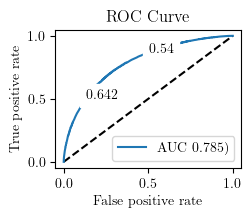

In [45]:
def ROC(y_test, y_proba, filename):
    print ('ROC()')
    print (filename)
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    
    N_median = np.median(y_proba[np.array(y_test)==0])
    P_median = np.median(y_proba[np.array(y_test)==1])
    print ('N_median, P_median = ', N_median, P_median)

    m = np.quantile(y_proba,0.50)
    p = np.quantile(y_proba,0.25)
    q = np.quantile(y_proba,0.75)
    
    Y = []
    for X in [
#        [m, str(round(m,3))],
#        [p, str(round(p,3))],
#        [q, str(round(q,3))],
        [N_median, str(round(N_median,3))],
        [P_median, str(round(P_median,3))],
    ]:
        difference_array = np.absolute(thresholds-X[0])
        index = difference_array.argmin()
        F = fpr[index]
        T = tpr[index]
        Y.append([X[0],X[1],F,T])
    
    auc_value = auc(fpr, tpr)
    plt.figure(figsize=(2.4,1.8)) # Create matplotlib figure
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='AUC {:.3f})'.format(auc_value))
    
    for y in Y:
#        plt.plot([y[2]], [y[3]], marker="o", markersize=20, markeredgecolor="white", markerfacecolor="white")
#        plt.annotate(
#            y[1], # this is the text
#            (y[2], y[3]), # these are the coordinates to position the label
#            ha='center' # horizontal alignment can be left, right or center
#        )
        plt.text(
            y[2], y[3], # these are the coordinates to position the label
            y[1], # this is the text
            backgroundcolor='white' # horizontal alignment can be left, right or center
        )
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC Curve')
    plt.legend(loc='best')
    plt.savefig('./Images/' + filename + '_ROC.png', bbox_inches="tight")
    plt.savefig('./Images/' + filename + '_ROC.pgf', bbox_inches="tight")
    plt.show()
    plt.close()
    print ()
    return 0

def Test_ROC():
    y_test = [0,0,0,0,0,1]*10000
#    y_proba = [abs(0.45 - y)+round(0.45*random.random(),2) for y in y_test]
    y_proba = [abs(0.45 - y)+round(0.45*random.normalvariate(mu=0.2, sigma=0.2),3) for y in y_test]
#    random.normalvariate(mu=0.0, sigma=1.0)
    y_test = np.array(y_test)
    y_proba = np.array(y_proba)
    print (y_test)
    print (y_proba)
    ROC(y_test, y_proba, "tmp")
    
Test_ROC()



## Build Idealized Results Plots
- The Plot_Prediciton and ROC_Curves functions take two lists (or np arrays) and a filename for saving the plots:
    - ROC(y_test, y_proba, filename):
    - Plot_Prediction(y_test, y_proba, filename):
    - y_test is the {0,1} binary and 
    - y_proba is the (0,1) continuous
- The Evaluate_Model(y_test, y_proba, y_pred, filename) takes three lists (or np arrays)
    - y_test is the {0,1} binary ground truth,
    - y_proba is the (0,1) continuous prediction, and
    - y_pred is the discrete {0,1} binary version of y_proba
- We want a 

Idealized_Results()
Move_Threshold()
<class 'numpy.ndarray'>
<class 'list'>
<class 'numpy.ndarray'>
120000 20000


,0,1,2,3,4,5,6
0,t,TN,FP,FN,TP,TPR,FPR
1,0.0,0,120000,0,20000,1.0,1.0
2,0.1,3566,116434,164,19836,0.9918,0.970283
3,0.2,22287,97713,511,19489,0.97445,0.814275
4,0.3,49641,70359,1138,18862,0.9431,0.586325
5,0.4,75214,44786,2240,17760,0.888,0.373217
6,0.5,93842,26158,4245,15755,0.78775,0.217983
7,0.6,105572,14428,7379,12621,0.63105,0.120233
8,0.7,113380,6620,11530,8470,0.4235,0.055167
9,0.8,117092,2908,16089,3911,0.19555,0.024233



Ideal
Plot_Prediction()
Ideal
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


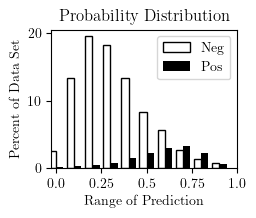


ROC()
Ideal
N_median, P_median =  0.33805043485035563 0.6644743664049473


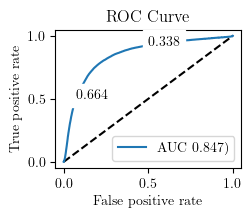


Evaluate_Model()
[[93842 26158]
 [ 4245 15755]]

[[0.6703     0.18684286]
 [0.03032143 0.11253571]]

- Accuracy_Metric:  0.7828357142851551
- Balanced_Accuracy_Metric:  0.7848833333310381
- Precision_Metric:  0.37589769283903346
- Balanced_Precision_Metric:  0.783259313270582
- Recall_Metric:  0.7877499999960612
- F1_Metric:  0.5089400766683823
- Balanced_F1_Metric:  0.78549833838216
- Gmean_Metric:  0.5421791777276461

0.783 & Accuracy \cr 
0.785 & Balanced Accuracy \cr 
0.376 & Precision \cr 
0.783 & Balanced Precision \cr 
0.788 & Recall \cr 
0.509 & F1 \cr 
0.785 & Balanced F1 \cr 
0.542 & Gmean \cr 

Ideal_50
Plot_Prediction()
Ideal_50
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


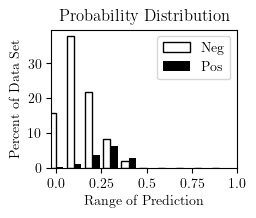


ROC()
Ideal_50
N_median, P_median =  0.16902521742517782 0.33223718320247364


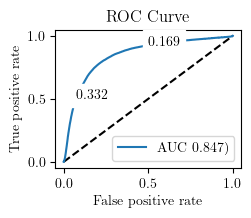


Evaluate_Model()
[[120000      0]
 [ 20000      0]]

[[0.85714286 0.        ]
 [0.14285714 0.        ]]

- Accuracy_Metric:  0.8571428571422449
- Balanced_Accuracy_Metric:  0.49999999999958333
- Precision_Metric:  0.0
- Balanced_Precision_Metric:  0.0
- Recall_Metric:  0.0
- F1_Metric:  1e-07
- Balanced_F1_Metric:  1e-07
- Gmean_Metric:  0.0

0.857 & Accuracy \cr 
0.500 & Balanced Accuracy \cr 
0.000 & Precision \cr 
0.000 & Balanced Precision \cr 
0.000 & Recall \cr 
0.000 & F1 \cr 
0.000 & Balanced F1 \cr 
0.000 & Gmean \cr 

Ideal_50_Shifted
Shift_y_proba()

N_median = 0.169, P_median = 0.332, center = 0.251
N_median = 0.418, P_median = 0.582, center = 0.500

Plot_Prediction()
Ideal_50_Shifted
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


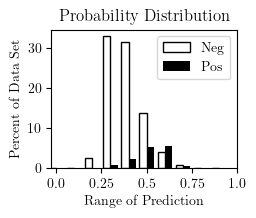


ROC()
Ideal_50_Shifted
N_median, P_median =  0.41839401711135205 0.5816059828886478


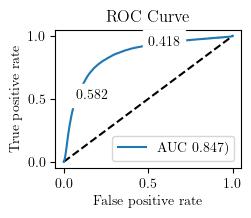


Evaluate_Model()
[[94019 25981]
 [ 4279 15721]]

[[0.67156429 0.18557857]
 [0.03056429 0.11229286]]

- Accuracy_Metric:  0.7838571428565829
- Balanced_Accuracy_Metric:  0.7847708333310417
- Precision_Metric:  0.3769843172980265
- Balanced_Precision_Metric:  0.7840441537067668
- Recall_Metric:  0.7860499999960697
- F1_Metric:  0.5095784080484711
- Balanced_F1_Metric:  0.785045895584682
- Gmean_Metric:  0.5434740758001068

0.784 & Accuracy \cr 
0.785 & Balanced Accuracy \cr 
0.377 & Precision \cr 
0.784 & Balanced Precision \cr 
0.786 & Recall \cr 
0.510 & F1 \cr 
0.785 & Balanced F1 \cr 
0.543 & Gmean \cr 

Ideal_50_Linear_Transform
Linear_Transform_y_proba()

a = 0.309, b = 0.694

Plot_Prediction()
Ideal_50_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


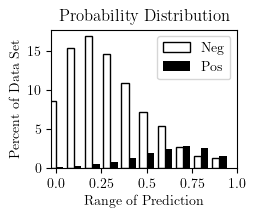


ROC()
Ideal_50_Linear_Transform
N_median, P_median =  0.30520614271176016 0.6876629895165378


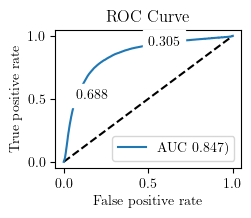


Evaluate_Model()
[[94497 25503]
 [ 4356 15644]]

[[0.67497857 0.18216429]
 [0.03111429 0.11174286]]

- Accuracy_Metric:  0.7867214285708666
- Balanced_Accuracy_Metric:  0.7848374999977163
- Precision_Metric:  0.38019782730118795
- Balanced_Precision_Metric:  0.7863479856241675
- Recall_Metric:  0.782199999996089
- F1_Metric:  0.5116850678846496
- Balanced_F1_Metric:  0.7842686081890854
- Gmean_Metric:  0.5471711652250633

0.787 & Accuracy \cr 
0.785 & Balanced Accuracy \cr 
0.380 & Precision \cr 
0.786 & Balanced Precision \cr 
0.782 & Recall \cr 
0.512 & F1 \cr 
0.784 & Balanced F1 \cr 
0.547 & Gmean \cr 

Ideal_Shift_to_FP_equals_r_TP
Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'list'>
y_proba is a  <class 'numpy.ndarray'>



,TP,FP,TP_RA,FP_RA,TP/FP,TP/FP_RA,bins
"(0.0565, 0.0611]",157,12,0.0,0.0,0.000000,0.000000,0.056492
"(0.0611, 0.0657]",198,7,0.0,0.0,0.000000,0.000000,0.061084
"(0.0657, 0.0703]",264,16,0.0,0.0,0.000000,0.000000,0.065677
"(0.0703, 0.0749]",270,6,0.0,0.0,0.000000,0.000000,0.070269
"(0.0749, 0.0795]",297,11,0.0,0.0,0.000000,0.000000,0.074861
"(0.0795, 0.084]",357,9,322.2,9.6,33.562500,0.000000,0.079454
"(0.084, 0.0886]",374,9,361.8,9.6,37.687500,0.000000,0.084046
"(0.0886, 0.0932]",375,8,396.8,10.1,39.287129,0.000000,0.088639
"(0.0932, 0.0978]",427,11,424.5,9.7,43.762887,0.000000,0.093231
"(0.0978, 0.102]",503,7,456.9,10.0,45.690000,0.000000,0.097824


                 TP   FP  TP_RA  FP_RA     TP/FP  TP/FP_RA      bins
(0.649, 0.654]  310  198  403.8  195.9  2.061256  2.039896  0.648923
[0.64892256]

Plot_Prediction()
tmp_Original
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


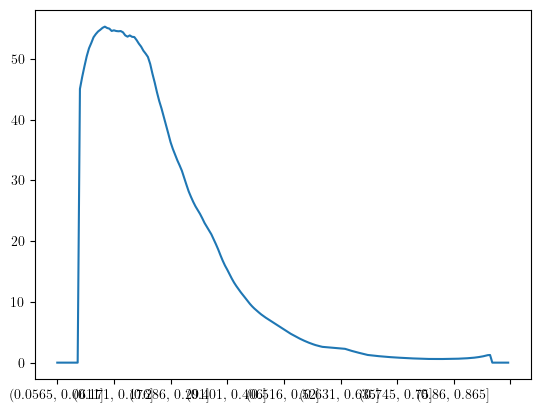

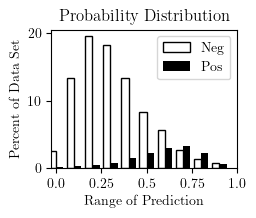


Plot_Prediction()
tmp_Shifted
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


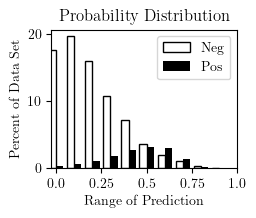


Plot_Prediction()
tmp_Dilated
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


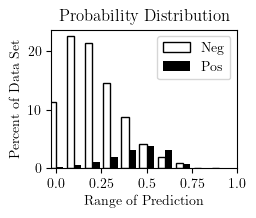


Plot_Prediction()
Ideal_Shift_to_FP_equals_r_TP
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


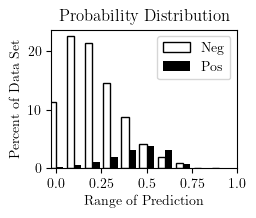


ROC()
Ideal_Shift_to_FP_equals_r_TP
N_median, P_median =  0.2373072474685045 0.5131415679867267


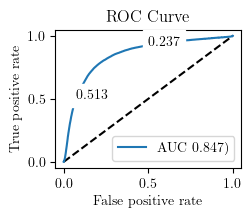


Evaluate_Model()
[[110412   9588]
 [  9334  10666]]

[[0.78865714 0.06848571]
 [0.06667143 0.07618571]]

- Accuracy_Metric:  0.8648428571422394
- Balanced_Accuracy_Metric:  0.7266999999982833
- Precision_Metric:  0.5266120272512758
- Balanced_Precision_Metric:  0.8696999347684279
- Recall_Metric:  0.5332999999973335
- F1_Metric:  0.5299350133018901
- Balanced_F1_Metric:  0.6611704504035886
- Gmean_Metric:  0.6960860049401187

0.865 & Accuracy \cr 
0.727 & Balanced Accuracy \cr 
0.527 & Precision \cr 
0.870 & Balanced Precision \cr 
0.533 & Recall \cr 
0.530 & F1 \cr 
0.661 & Balanced F1 \cr 
0.696 & Gmean \cr 



In [46]:
def Move_Threshold(y_proba, y_test):
    print ('Move_Threshold()')
    n = 10
    T = [x/n for x in range (n+1)]
    
    print (type(y_proba))
    print (type(y_test))
    y_test = np.array(y_test)
    print (type(y_test))
    N = y_proba[y_test==0]
    P = y_proba[y_test==1]
    print (len(N), len(P))

    A = [['t', 'TN', 'FP', 'FN', 'TP', 'TPR', 'FPR']]
    for t in T:
        TN = len(N[N<t])
        FP = len(N[N>t])
        FN = len(P[P<t])
        TP = len(P[P>t])
        TPR = TP/len(P)
        FPR = FP/len(N)
        A.append([t, TN, FP, FN, TP, TPR, FPR])
    display(pd.DataFrame(A))
    
    print ()


def Idealized_Results():
    print ('Idealized_Results()')
    # Set randomness
    np.random.seed(42) # NumPy
    random.seed(42) # Python
    tf.random.set_seed(42) # Tensorflow    

    shape, scale = 3.7, 0.1 # mean=4, std=2*sqrt(2)
    a = np.random.gamma(shape, scale, 120000)    
    a = np.where(a>1.0, random.random(), a)
    
    shape, scale = 3.7, 0.1 # mean=4, std=2*sqrt(2)
    b = np.random.gamma(shape, scale, 20000)    
    b = np.where(b>1.0, random.random(), b)
    b = 1-b
    
    y_proba = np.concatenate((a,b),axis=0)
    y_pred = K.round(y_proba)
    y_test = [0]*len(a) + [1]*len(b)
    
    Move_Threshold(y_proba, y_test)
    
    filename = 'Ideal'
    print (filename)
    Plot_Prediction(y_test, y_proba, filename)
    ROC(y_test, y_proba, filename)    
    Evaluate_Model(y_test, y_proba, y_pred, filename)    
    print ()
    
    filename = 'Ideal_50'
    print (filename)
    y_proba = 0.5 * y_proba
    y_pred = K.round(y_proba)
    Plot_Prediction(y_test, y_proba, filename)
    ROC(y_test, y_proba, filename)    
    Evaluate_Model(y_test, y_proba, y_pred, filename)    
    print ()

    filename = 'Ideal_50_Shifted'
    print (filename)
    y_test, y_proba, y_pred, filename = Shift_y_proba(y_test, y_proba, y_pred, filename)
    Plot_Prediction(y_test, y_proba, filename)
    ROC(y_test, y_proba, filename)    
    Evaluate_Model(y_test, y_proba, y_pred, filename)    
    print ()
    
    filename = 'Ideal_50_Linear_Transform'
    print (filename)
    y_test, y_proba, y_pred, filename = Linear_Transform_y_proba(y_test, y_proba, y_pred, filename)
    Plot_Prediction(y_test, y_proba, filename)
    ROC(y_test, y_proba, filename)    
    Evaluate_Model(y_test, y_proba, y_pred, filename)    
    print ()
    
    # Set randomness
    np.random.seed(42) # NumPy
    random.seed(42) # Python
    tf.random.set_seed(42) # Tensorflow    

    shape, scale = 3.7, 0.1 # mean=4, std=2*sqrt(2)
    a = np.random.gamma(shape, scale, 120000)    
    a = np.where(a>1.0, random.random(), a)
    
    shape, scale = 3.7, 0.1 # mean=4, std=2*sqrt(2)
    b = np.random.gamma(shape, scale, 20000)    
    b = np.where(b>1.0, random.random(), b)
    b = 1-b
    
    y_proba = np.concatenate((a,b),axis=0)
    y_pred = K.round(y_proba)
    y_test = [0]*len(a) + [1]*len(b)
    
    filename = 'Ideal_Shift_to_FP_equals_r_TP'
    print (filename)
    y_test, y_proba, y_pred, filename_tmp = Shift_y_proba_to_FP_equals_r_TP(y_test, y_proba, 2.0, filename)
    Plot_Prediction(y_test, y_proba, filename)
    ROC(y_test, y_proba, filename)    
    Evaluate_Model(y_test, y_proba, y_pred, filename)    
    print ()
    
    

    
Idealized_Results()

Plot_Prediction()
Awful
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


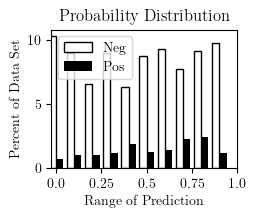


ROC()
Awful
N_median, P_median =  0.517315000332466 0.6124301189248178


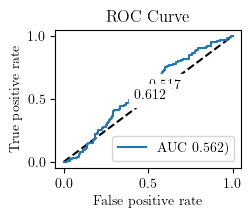


Evaluate_Model()
[[288 312]
 [ 40  60]]

[[0.41142857 0.44571429]
 [0.05714286 0.08571429]]

- Accuracy_Metric:  0.49714285707183675
- Balanced_Accuracy_Metric:  0.53999999966
- Precision_Metric:  0.16129032253728753
- Balanced_Precision_Metric:  0.5357142857134886
- Recall_Metric:  0.5999999994
- F1_Metric:  0.25423742123670484
- Balanced_F1_Metric:  0.5660378359020113
- Gmean_Metric:  0.2782433373955157

0.497 & Accuracy \cr 
0.540 & Balanced Accuracy \cr 
0.161 & Precision \cr 
0.536 & Balanced Precision \cr 
0.600 & Recall \cr 
0.254 & F1 \cr 
0.566 & Balanced F1 \cr 
0.278 & Gmean \cr 


In [47]:
def Awful_Results():
    # Set randomness
    np.random.seed(42) # NumPy
    random.seed(42) # Python
    tf.random.set_seed(42) # Tensorflow    
    
    shape, scale = 1.0, 0.5 # mean=4, std=2*sqrt(2)
    a = np.random.random(600)   
    
    b = np.random.random(100)    
    b = np.where(b>1.0, random.random(), b)
    b = 1-b
    
    y_proba = np.concatenate((a,b),axis=0)
    y_pred = K.round(y_proba)
    y_test = [0]*len(a) + [1]*len(b)
    
    filename = 'Awful'
    Plot_Prediction(y_test, y_proba, filename)
    ROC(y_test, y_proba, filename)    
    Evaluate_Model(y_test, y_proba, y_pred, filename)    
    
Awful_Results()

# Main()

Get_Data()
data.shape:  (619027, 82)
End Get_Data()

Remove_Pedestrian_Crashes()


0    591304
1     26801
2       922
Name: PEDS, dtype: int64

Removing 27723 crashes that involve a pedestrian.
Feature_Engineering_Cross_Two

591304 samples, 88735 hospitalized, 502569 not hospitalized
15.006663 percent of samples hospitalized
There are 5.663707 negative samples for each positive.

Thin_Features()
data.shape:  (591304, 40)
End Thin_Features()

AGE
AGE_x_SCH_BUS
AGE_x_SEX
BODY_TYP
BUS_USE
DAY_WEEK
EMER_USE
HOSPITAL
HOUR
INT_HWY
LGT_COND
MAKE
MODEL
MONTH
NUMOCCS
PERMVIT
PERNOTMVIT
PER_TYP
PJ
PSU
PVH_INVL
REGION
RELJCT1
RELJCT2
REL_ROAD
SCH_BUS
SEX
TYP_INT
URBANICITY
VALIGN
VEH_AGE
VE_FORMS
VE_TOTAL
VPROFILE
VSPD_LIM
VTRAFCON
VTRAFWAY
WEATHER
WRK_ZONE
YEAR

Get_Dummies

Split_Data()
(413912, 170) (413912,) 62114 70.0 %
(177392, 170) (177392,) 26621 30.0 %

X_train.shape =  (413912, 170)
X_test.shape =  (177392, 170)
y_train.shape =  (413912,)
y_test.shape =  (177392,)

type(X_train):  <class 'pandas.core.frame.DataFrame'>
type(X_test):  <class 'pandas.core.frame.DataFrame'>
type(y_train):  <class 'pandas.core.series.Series'>
type(y

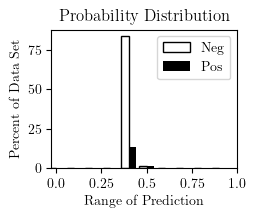


ROC()
AdaBoost_Hard_Tomek_0
N_median, P_median =  0.49442199680783794 0.4967401901935389


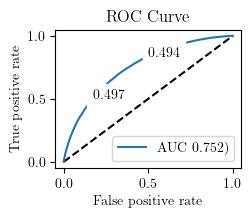


Evaluate_Model()
[[148358   2413]
 [ 23995   2626]]

[[0.83632858 0.01360264]
 [0.1352654  0.01480337]]

- Accuracy_Metric:  0.8511319563447894
- Balanced_Accuracy_Metric:  0.5413197618476276
- Precision_Metric:  0.5211351458519322
- Balanced_Precision_Metric:  0.8604043880552192
- Recall_Metric:  0.09864392772586061
- F1_Metric:  0.16588770174254222
- Balanced_F1_Metric:  0.1769957677397583
- Gmean_Metric:  0.7160968429082546

0.851 & Accuracy \cr 
0.541 & Balanced Accuracy \cr 
0.521 & Precision \cr 
0.860 & Balanced Precision \cr 
0.099 & Recall \cr 
0.166 & F1 \cr 
0.177 & Balanced F1 \cr 
0.716 & Gmean \cr 

Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>



,TP,FP,TP_RA,FP_RA,TP/FP,TP/FP_RA,bins
"(0.48889, 0.48896]",98,0,0.0,0.0,0.000000,0.000000,0.488892
"(0.48896, 0.48904]",122,2,0.0,0.0,0.000000,0.000000,0.488964
"(0.48904, 0.48911]",113,0,0.0,0.0,0.000000,0.000000,0.489037
"(0.48911, 0.48918]",135,0,0.0,0.0,0.000000,0.000000,0.489110
"(0.48918, 0.48926]",152,0,0.0,0.0,0.000000,0.000000,0.489183
"(0.48926, 0.48933]",152,5,150.6,1.4,107.571429,0.000000,0.489256
"(0.48933, 0.4894]",178,2,161.7,2.0,80.850000,0.000000,0.489328
"(0.4894, 0.48947]",173,1,173.6,2.1,82.666667,0.000000,0.489401
"(0.48947, 0.48955]",167,3,187.7,2.7,69.518519,0.000000,0.489474
"(0.48955, 0.48962]",216,1,200.0,2.7,74.074074,0.000000,0.489547


                     TP   FP  TP_RA  FP_RA     TP/FP  TP/FP_RA      bins
(0.49821, 0.49828]  536  268  510.7  262.4  1.946265  2.016359  0.498211
[0.49821117]

Plot_Prediction()
tmp_Original
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


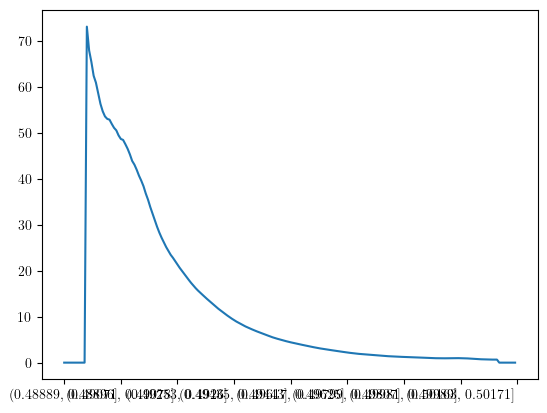

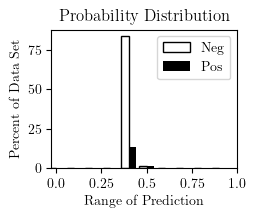


Plot_Prediction()
tmp_Shifted
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


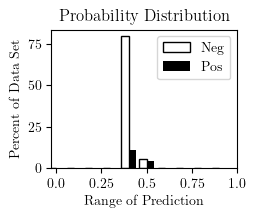


Plot_Prediction()
tmp_Dilated
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


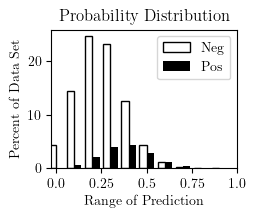


Plot_Prediction()
AdaBoost_Hard_Tomek_0_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


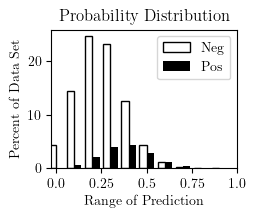


ROC()
AdaBoost_Hard_Tomek_0_Linear_Transform
N_median, P_median =  0.2946380607036012 0.4202772007410429


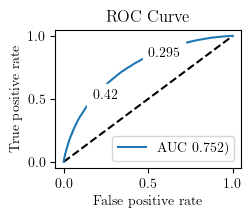


Evaluate_Model()
[[140924   9847]
 [ 19230   7391]]

[[0.79442139 0.05550983]
 [0.10840399 0.04166479]]

- Accuracy_Metric:  0.8360861820145011
- Balanced_Accuracy_Metric:  0.6061634933533067
- Precision_Metric:  0.4287620373568351
- Balanced_Precision_Metric:  0.8095606550865622
- Recall_Metric:  0.27763795499689103
- F1_Metric:  0.33703469268720854
- Balanced_F1_Metric:  0.41347520133285404
- Gmean_Metric:  0.6330554269026907

0.836 & Accuracy \cr 
0.606 & Balanced Accuracy \cr 
0.429 & Precision \cr 
0.810 & Balanced Precision \cr 
0.278 & Recall \cr 
0.337 & F1 \cr 
0.413 & Balanced F1 \cr 
0.633 & Gmean \cr 


Bagging()  Bagging_Hard_Tomek_0
Balance_Proba
Bagging_Hard_Tomek_0
Plot_Prediction()
Bagging_Hard_Tomek_0
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


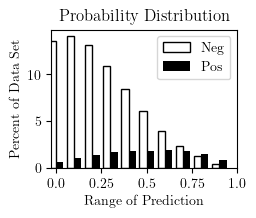


ROC()
Bagging_Hard_Tomek_0
N_median, P_median =  0.3 0.6


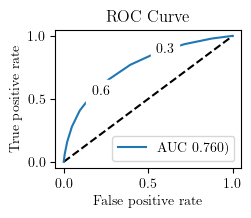


Evaluate_Model()
[[125633  25138]
 [ 12475  14146]]

[[0.70822247 0.14170876]
 [0.07032448 0.0797443 ]]

- Accuracy_Metric:  0.7879667628749955
- Balanced_Accuracy_Metric:  0.6823276603365659
- Precision_Metric:  0.36009571326657136
- Balanced_Precision_Metric:  0.7611715057791555
- Recall_Metric:  0.5313849968050359
- F1_Metric:  0.42928467997452735
- Balanced_F1_Metric:  0.6258530037615203
- Gmean_Metric:  0.5477746540477653

0.788 & Accuracy \cr 
0.682 & Balanced Accuracy \cr 
0.360 & Precision \cr 
0.761 & Balanced Precision \cr 
0.531 & Recall \cr 
0.429 & F1 \cr 
0.626 & Balanced F1 \cr 
0.548 & Gmean \cr 

Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>



,TP,FP,TP_RA,FP_RA,TP/FP,TP/FP_RA,bins
"(0.0, 0.005]",0,0,0.0,0.0,0.000000,0.000000,0.000
"(0.005, 0.01]",0,0,0.0,0.0,0.000000,0.000000,0.005
"(0.01, 0.015]",0,0,0.0,0.0,0.000000,0.000000,0.010
"(0.015, 0.02]",0,0,0.0,0.0,0.000000,0.000000,0.015
"(0.02, 0.025]",1,0,0.0,0.0,0.000000,0.000000,0.020
"(0.025, 0.03]",0,0,4.1,0.2,20.500000,0.000000,0.025
"(0.03, 0.035]",7,1,4.1,0.2,20.500000,0.000000,0.030
"(0.035, 0.04]",0,0,4.5,0.2,22.500000,0.000000,0.035
"(0.04, 0.045]",0,0,4.5,0.2,22.500000,0.000000,0.040
"(0.045, 0.05]",33,1,7.2,0.2,36.000000,0.000000,0.045


               TP  FP  TP_RA  FP_RA     TP/FP  TP/FP_RA   bins
(0.755, 0.76]   3   0    9.5    4.7  2.021277   1.98951  0.755
[0.755]

Plot_Prediction()
tmp_Original
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


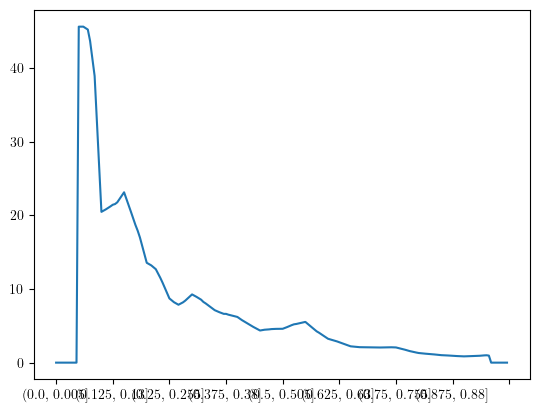

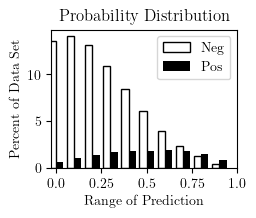


Plot_Prediction()
tmp_Shifted
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


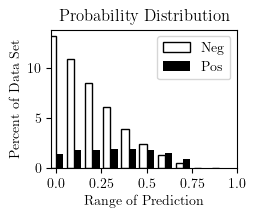


Plot_Prediction()
tmp_Dilated
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


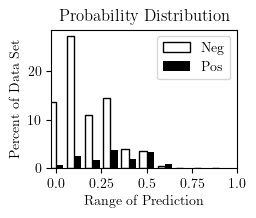


Plot_Prediction()
Bagging_Hard_Tomek_0_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


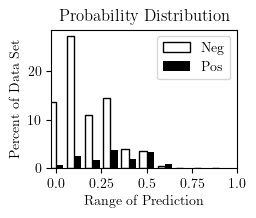


ROC()
Bagging_Hard_Tomek_0_Linear_Transform
N_median, P_median =  0.19867549668874168 0.3973509933774834


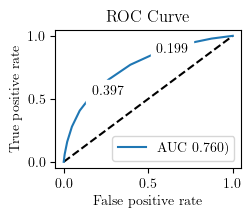


Evaluate_Model()
[[143513   7258]
 [ 19222   7399]]

[[0.80901619 0.04091504]
 [0.10835889 0.04170989]]

- Accuracy_Metric:  0.8507260755835377
- Balanced_Accuracy_Metric:  0.6148996193041685
- Precision_Metric:  0.5048099883980022
- Balanced_Precision_Metric:  0.8523688344112653
- Recall_Metric:  0.277938469628196
- F1_Metric:  0.35849615956423125
- Balanced_F1_Metric:  0.41918894031779486
- Gmean_Metric:  0.6931874376713547

0.851 & Accuracy \cr 
0.615 & Balanced Accuracy \cr 
0.505 & Precision \cr 
0.852 & Balanced Precision \cr 
0.278 & Recall \cr 
0.358 & F1 \cr 
0.419 & Balanced F1 \cr 
0.693 & Gmean \cr 


Balanced Random Forest Classifier  BRFC_Hard_Tomek_0
Balance_Proba
BRFC_Hard_Tomek_0
Plot_Prediction()
BRFC_Hard_Tomek_0
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


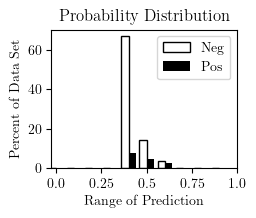


ROC()
BRFC_Hard_Tomek_0
N_median, P_median =  0.46985671359851366 0.4984513066167379


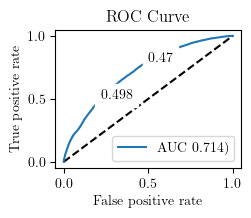


Evaluate_Model()
[[119102  31669]
 [ 13649  12972]]

[[0.6714057  0.17852553]
 [0.07694259 0.07312618]]

- Accuracy_Metric:  0.7445318841882698
- Balanced_Accuracy_Metric:  0.6386187248510626
- Precision_Metric:  0.2905848883307036
- Balanced_Precision_Metric:  0.6987845449797281
- Recall_Metric:  0.4872844746610297
- F1_Metric:  0.3640651059723029
- Balanced_F1_Metric:  0.5741772450881741
- Gmean_Metric:  0.47911209235295227

0.745 & Accuracy \cr 
0.639 & Balanced Accuracy \cr 
0.291 & Precision \cr 
0.699 & Balanced Precision \cr 
0.487 & Recall \cr 
0.364 & F1 \cr 
0.574 & Balanced F1 \cr 
0.479 & Gmean \cr 

Shift_y_proba_to_FP_equals_r_TP()
y_test is a  <class 'pandas.core.series.Series'>
y_proba is a  <class 'numpy.ndarray'>



,TP,FP,TP_RA,FP_RA,TP/FP,TP/FP_RA,bins
"(0.408, 0.41]",272,4,0.0,0.0,0.000000,0.000000,0.408492
"(0.41, 0.411]",235,3,0.0,0.0,0.000000,0.000000,0.409852
"(0.411, 0.413]",338,5,0.0,0.0,0.000000,0.000000,0.411212
"(0.413, 0.414]",295,10,0.0,0.0,0.000000,0.000000,0.412571
"(0.414, 0.415]",349,6,0.0,0.0,0.000000,0.000000,0.413931
"(0.415, 0.417]",440,7,386.0,7.8,49.487179,0.000000,0.415291
"(0.417, 0.418]",386,9,445.8,8.6,51.837209,0.000000,0.416651
"(0.418, 0.419]",441,11,528.3,11.2,47.169643,0.000000,0.418010
"(0.419, 0.421]",419,12,599.7,13.2,45.431818,0.000000,0.419370
"(0.421, 0.422]",685,11,670.5,16.4,40.884146,0.000000,0.420730


                 TP   FP  TP_RA  FP_RA     TP/FP  TP/FP_RA      bins
(0.604, 0.606]  228  117  230.1  113.4  2.029101  1.993245  0.604296
[0.60429628]

Plot_Prediction()
tmp_Original
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


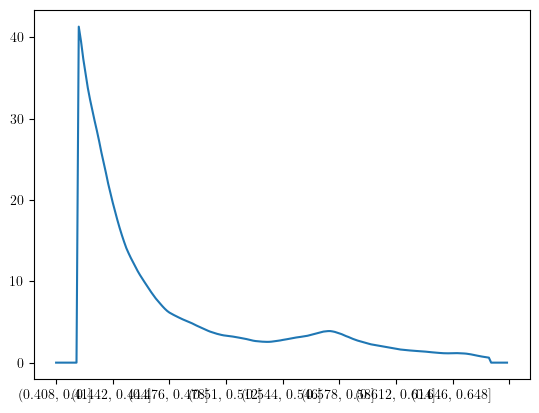

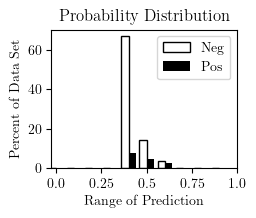


Plot_Prediction()
tmp_Shifted
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


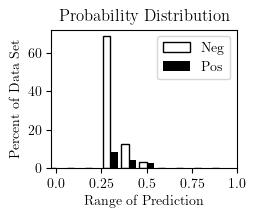


Plot_Prediction()
tmp_Dilated
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


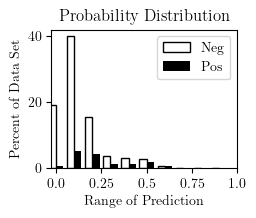


Plot_Prediction()
BRFC_Hard_Tomek_0_Linear_Transform
[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


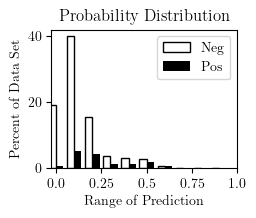


ROC()
BRFC_Hard_Tomek_0_Linear_Transform
N_median, P_median =  0.15586954959098398 0.22906429781622162


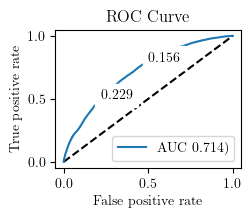


Evaluate_Model()
[[144947   5824]
 [ 22213   4408]]

[[0.81709998 0.03283124]
 [0.12521985 0.02484892]]

- Accuracy_Metric:  0.8419489041214699
- Balanced_Accuracy_Metric:  0.563477721854489
- Precision_Metric:  0.43080531664942523
- Balanced_Precision_Metric:  0.8108427581542236
- Recall_Metric:  0.16558356184904555
- F1_Metric:  0.23922080737230844
- Balanced_F1_Metric:  0.27500754411478506
- Gmean_Metric:  0.6435558390555726

0.842 & Accuracy \cr 
0.563 & Balanced Accuracy \cr 
0.431 & Precision \cr 
0.811 & Balanced Precision \cr 
0.166 & Recall \cr 
0.239 & F1 \cr 
0.275 & Balanced F1 \cr 
0.644 & Gmean \cr 


CPU times: user 1min 25s, sys: 8.37 s, total: 1min 33s
Wall time: 1min 37s


0

In [48]:
%%time
def Main():
    target = 'HOSPITAL'
    r_target = 2.0
    alpha_target = r_target/(r_target+1)
    

    # These functions run Tomek Links twice on all three versions of the dataset,
    # then save the results to file.  
#    Undersample_Data_Thin()
#    Undersample_Data_Really_Thin()
#    Undersample_Data_Thin_to_Minimal()

    data = Get_Data()
    data = data.astype('int64')
    
    data = Remove_Pedestrian_Crashes(data)
    data = Feature_Engineering_Cross_Two(data)

    N = len(data)
    n = len(data[data[target]==1])
    print ('%d samples, %d hospitalized, %d not hospitalized' % (N, n, N-n))
    print ('%f percent of samples hospitalized' % (n/N*100))
    print ('There are %f negative samples for each positive.' % ((N-n)/n))
    print ()
            
    data = Thin_Features(data)
#    data = Really_Thin_Features(data)
#    data = Thin_to_Minimal_Features(data)
    for feature in data:
        print (feature)
    print ()
    
    # Alternate dataset, for debugging
#    file_url = "http://storage.googleapis.com/download.tensorflow.org/data/heart.csv"
#    data = pd.read_csv(file_url)
#    target = 'target'

    # Decrease set size, for debugging
#    X_train, X_test, y_train, y_test = Split_Data(data, target, 0.95)
#    data = X_train
#    data['HOSPITAL'] = y_train

    data = Get_Dummies(data, target)
    X_train, X_test, y_train, y_test = Split_Data(data, target, 0.30)
    
    print ('X_train.shape = ', X_train.shape)
    print ('X_test.shape = ', X_test.shape)
    print ('y_train.shape = ', y_train.shape)
    print ('y_test.shape = ', y_test.shape)
    print ()
    
    print ('type(X_train): ', type(X_train))
    print ('type(X_test): ', type(X_test))
    print ('type(y_train): ', type(y_train))
    print ('type(y_test): ', type(y_test))
    print ()
    
    
    
    # To use Tomek Links, get the data from one of these sets of files
    
#    X_train = pd.read_csv('../../Big_Files/X_train_Thin_after_Tomek.csv')
#    y_train = pd.read_csv('../../Big_Files/y_train_Thin_after_Tomek.csv').squeeze()
#    X_test = pd.read_csv('../../Big_Files/X_test_Thin_after_Tomek.csv')
#    y_test = pd.read_csv('../../Big_Files/y_test_Thin_after_Tomek.csv').squeeze()
    
#    X_train = pd.read_csv('../../Big_Files/X_train_Thin_after_Tomek_Twice.csv')
#    y_train = pd.read_csv('../../Big_Files/y_train_Thin_after_Tomek_Twice.csv').squeeze()
#    X_test = pd.read_csv('../../Big_Files/X_test_Thin_after_Tomek_Twice.csv')
#    y_test = pd.read_csv('../../Big_Files/y_test_Thin_after_Tomek_Twice.csv').squeeze()
    
#    X_train = pd.read_csv('../../Big_Files/X_train_Really_Thin_after_Tomek.csv')
#    y_train = pd.read_csv('../../Big_Files/y_train_Really_Thin_after_Tomek.csv').squeeze()
#    X_test = pd.read_csv('../../Big_Files/X_test_Really_Thin_after_Tomek.csv')
#    y_test = pd.read_csv('../../Big_Files/y_test_Really_Thin_after_Tomek.csv').squeeze()
    
#    X_train = pd.read_csv('../../Big_Files/X_train_Really_Thin_after_Tomek_Twice.csv')
#    y_train = pd.read_csv('../../Big_Files/y_train_Really_Thin_after_Tomek_Twice.csv').squeeze()
#    X_test = pd.read_csv('../../Big_Files/X_test_Really_Thin_after_Tomek_Twice.csv')
#    y_test = pd.read_csv('../../Big_Files/y_test_Really_Thin_after_Tomek_Twice.csv').squeeze()
    
#    X_train = pd.read_csv('../../Big_Files/X_train_Thin_to_Minimal_after_Tomek.csv')
#    y_train = pd.read_csv('../../Big_Files/y_train_Thin_to_Minimal_after_Tomek.csv').squeeze()
#    X_test = pd.read_csv('../../Big_Files/X_test_Thin_to_Minimal_after_Tomek.csv')
#    y_test = pd.read_csv('../../Big_Files/y_test_Thin_to_Minimal_after_Tomek.csv').squeeze()
    
#    X_train = pd.read_csv('../../Big_Files/X_train_Thin_to_Minimal_after_Tomek_Twice.csv')
#    y_train = pd.read_csv('../../Big_Files/y_train_Thin_to_Minimal_after_Tomek_Twice.csv').squeeze()
#    X_test = pd.read_csv('../../Big_Files/X_test_Thin_to_Minimal_after_Tomek_Twice.csv')
#    y_test = pd.read_csv('../../Big_Files/y_test_Thin_to_Minimal_after_Tomek_Twice.csv').squeeze()
    
    print ('X_train.shape = ', X_train.shape)
    print ('X_test.shape = ', X_test.shape)
    print ('y_train.shape = ', y_train.shape)
    print ('y_test.shape = ', y_test.shape)
    print ()
    
    print ('type(X_train): ', type(X_train))
    print ('type(X_test): ', type(X_test))
    print ('type(y_train): ', type(y_train))
    print ('type(y_test): ', type(y_test))
    print ()
    
    """
    ##### Without Tomek
    print ('Without Tomek')
    print ()
    
    N = len(y_train)
    n = len(y_train[y_train==1])
    p = (N-n)/n
    alpha = p/(p+1)
    weights = class_weight.compute_class_weight('balanced',
                                            classes = np.unique(y_train),
                                            y = y_train).astype('float32')

    # Weights for each class = (nSamples Total)/(2* (nSamples in Class))
#    weights = [1.0,1.0]
#    weights = [0.55,5.5]

    print ()
    print ()
    print ('------------------------------------------')
    print ('BinaryFocalCrossentropy same as Alpha Weighted')
    filename = 'BFC_before_Tomek_alpha_equal_alpha_gamma_0_0'
    N = len(y_train)
    n = len(y_train[y_train==1])
    p = (N-n)/n
    alpha = p/(p+1)

    model = Make_Simple_Model(X_train)
    loss_function = tf.keras.losses.BinaryFocalCrossentropy(
        apply_class_balancing=True,
        alpha=alpha,
        gamma=0.0,
#        from_logits=False,
#        label_smoothing=0.0,
#        axis=-1,
#        reduction=losses_utils.ReductionV2.AUTO,
#        name='binary_focal_crossentropy'
    )
    model = Train_Simple_Model (X_train, X_test, y_train, y_test, model, loss_function, r_target, filename)
    
    print ()
    print ()
    print ('------------------------------------------')
    print ('BinaryFocalCrossentropy same as Alpha Weighted')
    filename = 'BFC_before_Tomek_alpha_equal_alpha_target_gamma_0_0'
    N = len(y_train)
    n = len(y_train[y_train==1])
    p = (N-n)/n
    alpha = p/(p+1)

    model = Make_Simple_Model(X_train)
    loss_function = tf.keras.losses.BinaryFocalCrossentropy(
        apply_class_balancing=True,
        alpha=alpha_target,
        gamma=0.0,
#        from_logits=False,
#        label_smoothing=0.0,
#        axis=-1,
#        reduction=losses_utils.ReductionV2.AUTO,
#        name='binary_focal_crossentropy'
    )
    model = Train_Simple_Model (X_train, X_test, y_train, y_test, model, loss_function, r_target, filename)
    
    
    print ()
    print ()
    print ('------------------------------------------')
    print ('BinaryFocalCrossentropy')
    filename = 'BFC_before_Tomek_alpha_equal_alpha_target_gamma_2_0'
    N = len(y_train)
    n = len(y_train[y_train==1])
    p = (N-n)/n
    alpha = p/(p+1)

    model = Make_Simple_Model(X_train)
    loss_function = tf.keras.losses.BinaryFocalCrossentropy(
        apply_class_balancing=True,
        alpha=alpha_target,
        gamma=2.0,
#        from_logits=False,
#        label_smoothing=0.0,
#        axis=-1,
#        reduction=losses_utils.ReductionV2.AUTO,
#        name='binary_focal_crossentropy'
    )
    model = Train_Simple_Model (X_train, X_test, y_train, y_test, model, loss_function, r_target, filename)
    """
    
    filename = 'AdaBoost_Hard_Tomek_0'
    AdaBoost(X_train, X_test, y_train, y_test, r_target, filename)
    filename = 'Bagging_Hard_Tomek_0'
    Bagging(X_train, X_test, y_train, y_test, r_target, filename)
    filename = 'BRFC_Hard_Tomek_0'
    Balanced_Random_Forest_Classifier(X_train, X_test, y_train, y_test, r_target, filename)
    
    return 0

    #####
    #
    # With Tomek Once
    #
    #####
    
    X_train = pd.read_csv('../../Big_Files/X_train_Thin_after_Tomek.csv')
    y_train = pd.read_csv('../../Big_Files/y_train_Thin_after_Tomek.csv').squeeze()
    X_test = pd.read_csv('../../Big_Files/X_test_Thin_after_Tomek.csv')
    y_test = pd.read_csv('../../Big_Files/y_test_Thin_after_Tomek.csv').squeeze()
    
    
    print ()
    print ()
    print ('------------------------------------------')
    print ('BinaryFocalCrossentropy Tomek once')
    filename = 'BFC_Tomek_Once_alpha_equal_alpha_gamma_2_0'
    N = len(y_train)
    n = len(y_train[y_train==1])
    p = (N-n)/n
    alpha = p/(p+1)

    model = Make_Simple_Model(X_train)
    loss_function = tf.keras.losses.BinaryFocalCrossentropy(
        apply_class_balancing=True,
        alpha=alpha,
        gamma=2.0,
#        from_logits=False,
#        label_smoothing=0.0,
#        axis=-1,
#        reduction=losses_utils.ReductionV2.AUTO,
#        name='binary_focal_crossentropy'
    )
    model = Train_Simple_Model (X_train, X_test, y_train, y_test, model, loss_function, r_target, filename)
    
    
    filename = 'AdaBoost_Hard_Tomek_1'
    AdaBoost(X_train, X_test, y_train, y_test, r_target, filename)
    filename = 'Bagging_Hard_Tomek_1'
    Bagging(X_train, X_test, y_train, y_test, r_target, filename)
    filename = 'BRFC_Hard_Tomek_1'
    Balanced_Random_Forest_Classifier(X_train, X_test, y_train, y_test, r_target, filename)



    #####
    #
    # Really Thin Features
    #
    #####
    
    data = Get_Data()
    data = data.astype('int64')
    
    data = Remove_Pedestrian_Crashes(data)
    data = Feature_Engineering_Cross_Two(data)

    N = len(data)
    n = len(data[data[target]==1])
    print ('%d samples, %d hospitalized, %d not hospitalized' % (N, n, N-n))
    print ('%f percent of samples hospitalized' % (n/N*100))
    print ('There are %f negative samples for each positive.' % ((N-n)/n))
    print ()
            
#    data = Thin_Features(data)
    data = Really_Thin_Features(data)
#    data = Thin_to_Minimal_Features(data)
    print ('Really_Thin_Features')
    for feature in data:
        print (feature)
    print ()

    data = Get_Dummies(data, target)
    X_train, X_test, y_train, y_test = Split_Data(data, target, 0.30)
    
    print ()
    print ()
    print ('------------------------------------------')
    print ('BinaryFocalCrossentropy')
    filename = 'BFC_before_Tomek_Really_Thin_alpha_equal_alpha_gamma_2_0'
    N = len(y_train)
    n = len(y_train[y_train==1])
    p = (N-n)/n
    alpha = p/(p+1)

    model = Make_Simple_Model(X_train)
    loss_function = tf.keras.losses.BinaryFocalCrossentropy(
        apply_class_balancing=True,
        alpha=alpha,
        gamma=2.0,
#        from_logits=False,
#        label_smoothing=0.0,
#        axis=-1,
#        reduction=losses_utils.ReductionV2.AUTO,
#        name='binary_focal_crossentropy'
    )
    model = Train_Simple_Model (X_train, X_test, y_train, y_test, model, loss_function, r_target, filename)
    
    
    filename = 'AdaBoost_Medium_Tomek_0'
    AdaBoost(X_train, X_test, y_train, y_test, r_target, filename)
    filename = 'Bagging_Medium_Tomek_0'
    Bagging(X_train, X_test, y_train, y_test, r_target, filename)
    filename = 'BRFC_Medium_Tomek_0'
    Balanced_Random_Forest_Classifier(X_train, X_test, y_train, y_test, r_target, filename)



    #####
    #
    # Thin_to_Minimal
    #
    #####
    
    data = Get_Data()
    data = data.astype('int64')
    
    data = Remove_Pedestrian_Crashes(data)
    data = Feature_Engineering_Cross_Two(data)

    N = len(data)
    n = len(data[data[target]==1])
    print ('%d samples, %d hospitalized, %d not hospitalized' % (N, n, N-n))
    print ('%f percent of samples hospitalized' % (n/N*100))
    print ('There are %f negative samples for each positive.' % ((N-n)/n))
    print ()
            
#    data = Thin_Features(data)
#    data = Really_Thin_Features(data)
    data = Thin_to_Minimal_Features(data)
    print ('Thin to Minimal')
    for feature in data:
        print (feature)
    print ()

    data = Get_Dummies(data, target)
    X_train, X_test, y_train, y_test = Split_Data(data, target, 0.30)
    
    print ()
    print ()
    print ('------------------------------------------')
    print ('BinaryFocalCrossentropy')
    filename = 'BFC_before_Tomek_Thin_to_Minimal_alpha_equal_alpha_gamma_2_0'
    N = len(y_train)
    n = len(y_train[y_train==1])
    p = (N-n)/n
    alpha = p/(p+1)

    model = Make_Simple_Model(X_train)
    loss_function = tf.keras.losses.BinaryFocalCrossentropy(
        apply_class_balancing=True,
        alpha=alpha,
        gamma=2.0,
#        from_logits=False,
#        label_smoothing=0.0,
#        axis=-1,
#        reduction=losses_utils.ReductionV2.AUTO,
#        name='binary_focal_crossentropy'
    )
    model = Train_Simple_Model (X_train, X_test, y_train, y_test, model, loss_function, r_target, filename)
    
    
    filename = 'AdaBoost_Easy_Tomek_0'
    AdaBoost(X_train, X_test, y_train, y_test, r_target, filename)
    filename = 'Bagging_Easy_Tomek_0'
    Bagging(X_train, X_test, y_train, y_test, r_target, filename)
    filename = 'BRFC_Easy_Tomek_0'
    Balanced_Random_Forest_Classifier(X_train, X_test, y_train, y_test, r_target, filename)



    
    
    return 0
        
Main()


